# Trackintel case study - Tracking dataset comparison

#### Imports

In [1]:
import numpy as np

In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import psycopg2
import json
import seaborn as sns
from collections import defaultdict
from shapely.geometry import Point
import trackintel as ti
from trackintel.analysis.tracking_quality import temporal_tracking_quality

In [3]:
import warnings
warnings.filterwarnings('ignore')

### PostGIS setup

Note: This notebook assumes that the data of the respective tracking studies is already preprocessed and is stored in a PostGIS database. Specifically, we assume that all aggregation levels up to trips (i.e. positionfixes, staypoints, triplegs and trips) are precomputed. These data are loaded in this notebook via the following connection

In [4]:
DBLOGIN_FILE = os.path.join("../mobility-graph-representation/dblogin.json")
DBLOGIN_FILE = r"C:\Users\henry\OneDrive\Programming\21_mobility-graph-clustering\dblogin.json"
with open(DBLOGIN_FILE) as json_file:
    LOGIN_DATA = json.load(json_file)

con = psycopg2.connect(
        dbname=LOGIN_DATA["database"],
        user=LOGIN_DATA["user"],
        password=LOGIN_DATA["password"],
        host=LOGIN_DATA["host"],
        port=LOGIN_DATA["port"],
)

#### Included tracking studies

In [5]:
studies = ["gc1", "gc2", "yumuv_graph_rep", "geolife"]

# for plotting later:
study_mapping = {"gc1":"Green Class 1", "gc2": "Green Class 2", "yumuv_graph_rep": "Yumuv", "geolife":"Geolife"}

#### The information per study is collected in a dictionary

In [6]:
out_dict = {study: {} for study in studies}

# specify Output path
out_path = "1paper"

LIMIT = " LIMIT 1000"

### merge staypoints

In [ ]:
# get staypoints
df_temp_list = []
for ix, study in enumerate(studies):
    sql = f"SELECT * FROM {study}.staypoints"
    df_temp = ti.io.read_staypoints_postgis(sql, con, index_col="id", geom_col="geom")
    df_temp['study'] = study
    df_temp.index = df_temp.index + ix * 10e7 # ensure unique index over studies
    df_temp_list.append(df_temp)

staypoints = pd.concat(df_temp_list)

In [24]:
user_study_matching = staypoints[['user_id', 'study']].drop_duplicates()
user_study_matching = user_study_matching.set_index('user_id')

### Merge triplegs


In [12]:
# get triplegs
df_temp_list = []
for ix, study in enumerate(studies):
    print(study)
    sql = f"SELECT * FROM {study}.triplegs limit 5000"
    df_temp = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col="geom")
    df_temp['study'] = study
    df_temp.index = df_temp.index + ix * 10e7 # ensure unique index over studies
    df_temp_list.append(df_temp)

triplegs = pd.concat(df_temp_list)

gc1
gc2
yumuv_graph_rep
geolife


### create trips

In [28]:
staypoints, triplegs, trips = ti.preprocessing.triplegs.generate_trips(staypoints=sp, triplegs=tpls, gap_threshold=15, add_geometry=True)
trips = trips.join(user_study_matching, on='user_id')

### create tours

In [29]:
trips, tours = ti.preprocessing.generate_tours(trips, staypoints=staypoints)
tours = tours.join(user_study_matching, on='user_id')

### create locations

In [37]:
locations = ti.preprocessing.generate_locations(staypoints, epsilon=30, num_samples=1, 
                                                distance_metric='haversine', print_progress=True,
                                                n_jobs=4)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 782/1171 [00:18<00:03, 121.03it/s]

KeyboardInterrupt: 

In [36]:
locations = locations.join(user_study_matching, on='user_id')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1171/1171 [00:26<00:00, 44.02it/s]


KeyboardInterrupt: 

### statistics

In [46]:
overview_df = pd.DataFrame(index=studies)

nr_user = trips['user_id'].nunique()

# nb staypooints
overview_df['nr_staypoints'] = staypoints.groupby(by=['study']).size()
overview_df['nr_staypoints_per_user'] = overview_df['nr_staypoints']/nr_user

# nb triplegs
overview_df['nr_triplegs'] = triplegs.groupby(by=['study']).size()
overview_df['nr_triplegs_per_user'] = overview_df['nr_triplegs']/nr_user

# nb trips
overview_df['nr_trips'] = trips.groupby(by=['study']).size()
overview_df['nr_trips_per_user'] = overview_df['nr_trips']/nr_user
# nb locations
#overview_df['nr_locations'] = locations.groupby(by=['study']).size()
#overview_df['nr_locations_per_user'] = #overview_df['nr_locations']/nr_user

# nb tours
overview_df['nr_tours'] = tours.groupby(by=['study']).size()
overview_df['nr_tours_per_user'] = overview_df['nr_tours']/nr_user



In [47]:
overview_df

,nr_staypoints,nr_staypoints_per_user,nr_triplegs,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_tours,nr_tours_per_user
gc1,294823,318.383369,5000,5.399568,4147,4.478402,517,0.558315
gc2,80258,86.671706,5000,5.399568,4425,4.778618,374,0.403888
yumuv_graph_rep,300692,324.721382,5000,5.399568,4925,5.318575,73,0.078834
geolife,28877,31.184665,5000,5.399568,5000,5.399568,1363,1.471922


## 1) Processing of tours

In [15]:
# load trips into memory
df_temp_list = []
for study in studies:
    sql = f"SELECT * FROM {study}.trips {LIMIT}"
    df_temp = ti.io.read_trips_postgis(sql, con, index_col="id", geom_col="geom")
    df_temp['study'] = study
    df_temp_list.append(df_temp)
    


In [17]:
df_temp.user_id.unique()

array([0, 1, 2, 3], dtype=int64)

In [ ]:
# generate tours and collect in dictionary
tours_by_study = {}
for study in studies:
    trips = trips_by_study[study]
    trips_w_tours, tours = ti.preprocessing.generate_tours(trips)
    trips_by_study[study] = trips_w_tours
    tours_by_study[study] = tours

## 2) Get general stats
* How many staypoints / triplegs / trips / tours does each study have?
* How many users for each study?

In [46]:
for study in studies:
    nr_users = pd.read_sql(f"SELECT count(distinct(user_id)) FROM {study}.trips", con).values[0][0]
    out_dict[study]["nr_user"] = nr_users
    
    nr_trips = pd.read_sql(f"SELECT COUNT(*) FROM {study}.trips", con)
    nr_trips = nr_trips.values[0][0]
    normed_nr_trips = nr_trips/nr_users
    out_dict[study]["nr_trips"] = nr_trips
    out_dict[study]["nr_trips_per_user"] = round(normed_nr_trips)
    
    nr_staypoints = pd.read_sql(f"SELECT count(*) FROM {study}.staypoints", con).values[0][0]
    out_dict[study]["nr_sp"] = nr_staypoints
    out_dict[study]["nr_sp_per_user"] = nr_staypoints / nr_users
    
    nr_location = pd.read_sql(f"SELECT count(*) FROM {study}.locations", con).values[0][0]
    out_dict[study]["nr_loc"] = nr_location
    out_dict[study]["nr_loc_per_user"] = nr_location / nr_users
    
    nr_tpls = pd.read_sql(f"SELECT count(*) FROM {study}.triplegs", con).values[0][0]
    out_dict[study]["nr_tpls"] = nr_tpls
    out_dict[study]["nr_tpls_per_user"] = nr_tpls / nr_users
    
    # tours - from dictionary above
    out_dict[study]["nr_tours"] = len(tours_by_study[study])
    out_dict[study]["nr_tours_per_user"] = len(tours_by_study[study]) / out_dict[study]["nr_user"]

In [47]:
pd.DataFrame(out_dict).swapaxes(1,0).astype(int)

,nr_user,nr_trips,nr_trips_per_user,nr_sp,nr_sp_per_user,nr_loc,nr_loc_per_user,nr_tpls,nr_tpls_per_user
gc1,139,238305,1714,294823,2121,104497,751,465189,3346
gc2,50,61337,1227,80258,1605,35715,714,128618,2572
yumuv_graph_rep,813,245105,301,300692,369,127317,156,502288,617
geolife,182,30205,166,28877,158,13575,74,30205,165


## 3) Add further details

* How many trips comprise one tour on average? How many triplegs comprise a trip?
* What is the average trip duration / distance?

#### Number of hops in tours

In [11]:
tours['nb_hops'] = tours["trips"].apply(lambda x: len(x))

for study in studies:
    tour_study = tours_by_study[study]
    nr_hops_per_tour = tour_study["trips"].apply(lambda x: len(x))
    out_dict[study]["avg_hops_tours"] = np.mean(nr_hops_per_tour.values)

#### Trip duration

In [394]:
for study in studies:
    trips_test = trips_by_study[study]
    trips_test["duration"] = trips_test["finished_at"] - trips_test["started_at"]
    mean_dur = trips_test["duration"].mean().total_seconds() / 3600
    std_dur = trips_test["duration"].std().total_seconds() / 3600

    out_dict[study]["mean_trip_dur"] = round(mean_dur, 2)
    out_dict[study]["std_trip_dur"] = round(std_dur, 2)

#### Overall tracking period and number of trips per day per user

In [ ]:
for study in studies:
    trips_test = trips_by_study[study]
    grouped = trips_test.reset_index().groupby("user_id")
    
    tracking_dur_by_user = grouped.apply(lambda x: (x["finished_at"].max() - x["started_at"].min()).total_seconds() / (3600 * 24))
    
    out_dict[study]["mean_tracking_period"] = tracking_dur_by_user.mean()
    out_dict[study]["std_tracking_period"] = tracking_dur_by_user.std()

    tracking_dur_by_user = pd.DataFrame(tracking_dur_by_user, columns=["tracking duration"])
    # remove outliers for per user analysis
    tracking_dur_by_user = tracking_dur_by_user[tracking_dur_by_user["tracking duration"] > 2]
    
    nr_trips_user = grouped.agg({"id": "count"})
    nr_trips_user = nr_trips_user.merge(tracking_dur_by_user, left_index=True, right_index=True, how="inner")
    trips_user_per_day = nr_trips_user["id"] / nr_trips_user["tracking duration"]
    out_dict[study]["nr_trips_per_user_per_day"] = trips_user_per_day.mean()
    

#### Trip distance

In [6]:
tpls_by_study = {}
for study in ["geolife"]:
    geom_col = "geometry" if study == "yumuv_graph_rep" else "geom"
    sql = f"SELECT * FROM {study}.triplegs"
    tpls_in = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col=geom_col)
    tpls_in["length"] = ti.geogr.distances.calculate_haversine_length(tpls_in)
    tpls_by_study[study] = tpls_in
    
    # # load from intermediate storage instead
    # trip_length = pd.read_csv(f"1paper/data_properties/{study}_tpls_length.csv")
    
    # sum lengths over trips
    trip_length = tpls_in.groupby("trip_id").agg({"trip_id": "count", "length":"sum"})
    
    print("nr_legs_per_trip", np.mean(trip_length["trip_id"]))
    print("avg_trip_length", np.mean(trip_length["length"]))
    
    out_dict[study]["nr_legs_per_trip"] = round(np.mean(trip_length["trip_id"]), 2)
    out_dict[study]["avg_trip_length"] =  int(np.mean(trip_length["length"]))
    out_dict[study]["std_trip_length"] =  int(np.std(trip_length["length"]))
    

#### Tracking quality

In [ ]:
tracking_quality_dfs = {}
for study in studies:
    
    sql = f"SELECT * FROM {study}.staypoints"
    sp_loaded = ti.io.read_staypoints_postgis(sql, con, index_col="id", geom_col="geom")

    geom_col = "geometry" if study=="yumuv_graph_rep" else "geom"
    sql = f"SELECT * FROM {study}.triplegs"
    tpls_loaded = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col=geom_col)
    
    # merge sp and tpls
    all_trace = pd.merge(sp_loaded, tpls_loaded, how="outer")
    tracking_quality = temporal_tracking_quality(all_trace)
    tracking_quality_dfs[study] = tracking_quality
    
    # collect results
    print(study)
    print("Mean tracking quality", np.mean(tracking_quality["quality"]))
    print("std:", np.std(tracking_quality["quality"]))
    out_dict[study]["mean_tracking_quality"] = np.mean(tracking_quality["quality"])
    out_dict[study]["std_tracking_quality"] = np.std(tracking_quality["quality"])


#### Save tracking quality dataframes for plotting later

In [57]:
tracking_quality_dfs_new = {key: pd.DataFrame(df) for key, df in tracking_quality_dfs.items()}
with open(os.path.join(out_path, "tracking_quality_dfs.json"), "wb") as outfile:
    pickle.dump(tracking_quality_dfs_new, outfile)

## 4) Finalize results in two tables

In [ ]:
# Make DataFrame from out_dict and save to csv
df = pd.DataFrame(out_dict).swapaxes(1,0)
df.to_csv(os.path.join(out_path, "trackintel_casestudy_df.csv"))

In [30]:
# load df
df = pd.read_csv(os.path.join(out_path, "trackintel_casestudy_df.csv"), index_col="Unnamed: 0")

#### 4.1) Table with simple dataset stats

In [16]:
# basic info
df_basic = df[["nr_user","mean_tracking_period", "std_tracking_period", "nr_loc", "nr_sp", "nr_tpls", "nr_trips", "nr_tours"]].astype(int)
df_basic["Tracking period (std)"] = df_basic.apply(lambda x: f"{x['mean_tracking_period']} ({x['std_tracking_period']})", axis=1)
df_basic["Available"] = "Staypoints, Triplegs"
df_basic["Study type"] = "GNSS (app)"

# rename columns and index
df_basic = df_basic.rename(columns={"Available": "Input", "nr_user": "Users", "nr_loc": "Locations", "nr_sp": "Staypoints", "nr_tpls": "Triplegs", 
                        "nr_trips": "Trips", "nr_tours": "Tours"}, 
                        index=study_mapping).drop(columns=["mean_tracking_period", "std_tracking_period"])
# select the columns in the right order
df_basic = df_basic[["Users", 'Tracking period (std)' , "Input", "Study type", "Locations", "Staypoints", "Triplegs", "Trips", "Tours"]]

df_basic
# print(df_basic.to_latex())

,Users,Tracking period (std),Input,Study type,Locations,Staypoints,Triplegs,Trips,Tours
Green Class 1,139,401 (59),"Staypoints, Triplegs",GNSS (app),104497,294823,465189,238305,81612
Green Class 2,50,314 (76),"Staypoints, Triplegs",GNSS (app),35715,80258,128618,61337,18494
Yumuv,813,86 (39),"Staypoints, Triplegs",GNSS (app),127317,300692,502288,245105,91265
Geolife,182,187 (438),"Staypoints, Triplegs",GNSS (app),13575,28877,30205,30205,7522


#### 4.2) Table with analysis

In [25]:
# Analysis table
detailed = df[["nr_trips_per_user_per_day", "mean_trip_dur", "std_trip_dur", "avg_hops_tours", "nr_legs_per_trip", "avg_trip_length", "std_trip_length", "mean_tracking_quality", "std_tracking_quality"]]
detailed = detailed.round(2)
# Incorporate mean and std in one cell
detailed["Trip distance (std)"] = detailed.apply(lambda x: f"{int(x['avg_trip_length'])} ({int(x['std_trip_length'])})", axis=1)
detailed["Trip duration (std)"] = detailed.apply(lambda x: f"{x['mean_trip_dur']} ({x['std_trip_dur']})", axis=1)
detailed["Tracking quality (std)"] = detailed.apply(lambda x: f"{x['mean_tracking_quality']} ({x['std_tracking_quality']})", axis=1)

detailed = detailed.rename(columns={"nr_trips_per_user_per_day": "Trips per day", 
                                   "avg_hops_tours": "Trips per tour", 
                                   "nr_legs_per_trip": "Legs per trip"}, 
                          index={"gc1":"Green Class 1", "gc2": "Green Class 2", "yumuv_graph_rep": "Yumuv", "geolife":"Geolife"}
                          ).drop(["avg_trip_length", "std_trip_length", "mean_tracking_quality", "std_tracking_quality",
                                  "mean_trip_dur", "std_trip_dur"
                                 ], axis=1)

detailed
# print(detailed.to_latex())

,Trips per day,Trips per tour,Legs per trip,Trip distance (std),Tracking quality (std)
Green Class 1,4.26,3.03,1.95,27835 (482986),0.85 (0.17)
Green Class 2,3.80,3.08,2.10,38569 (877808),0.75 (0.24)
Yumuv,3.44,2.78,2.05,13783 (90143),0.77 (0.23)
Geolife,1.43,2.41,1.00,36135 (3164424),0.4 (0.32)


## 5) KDE plot for user tracking quality distribution

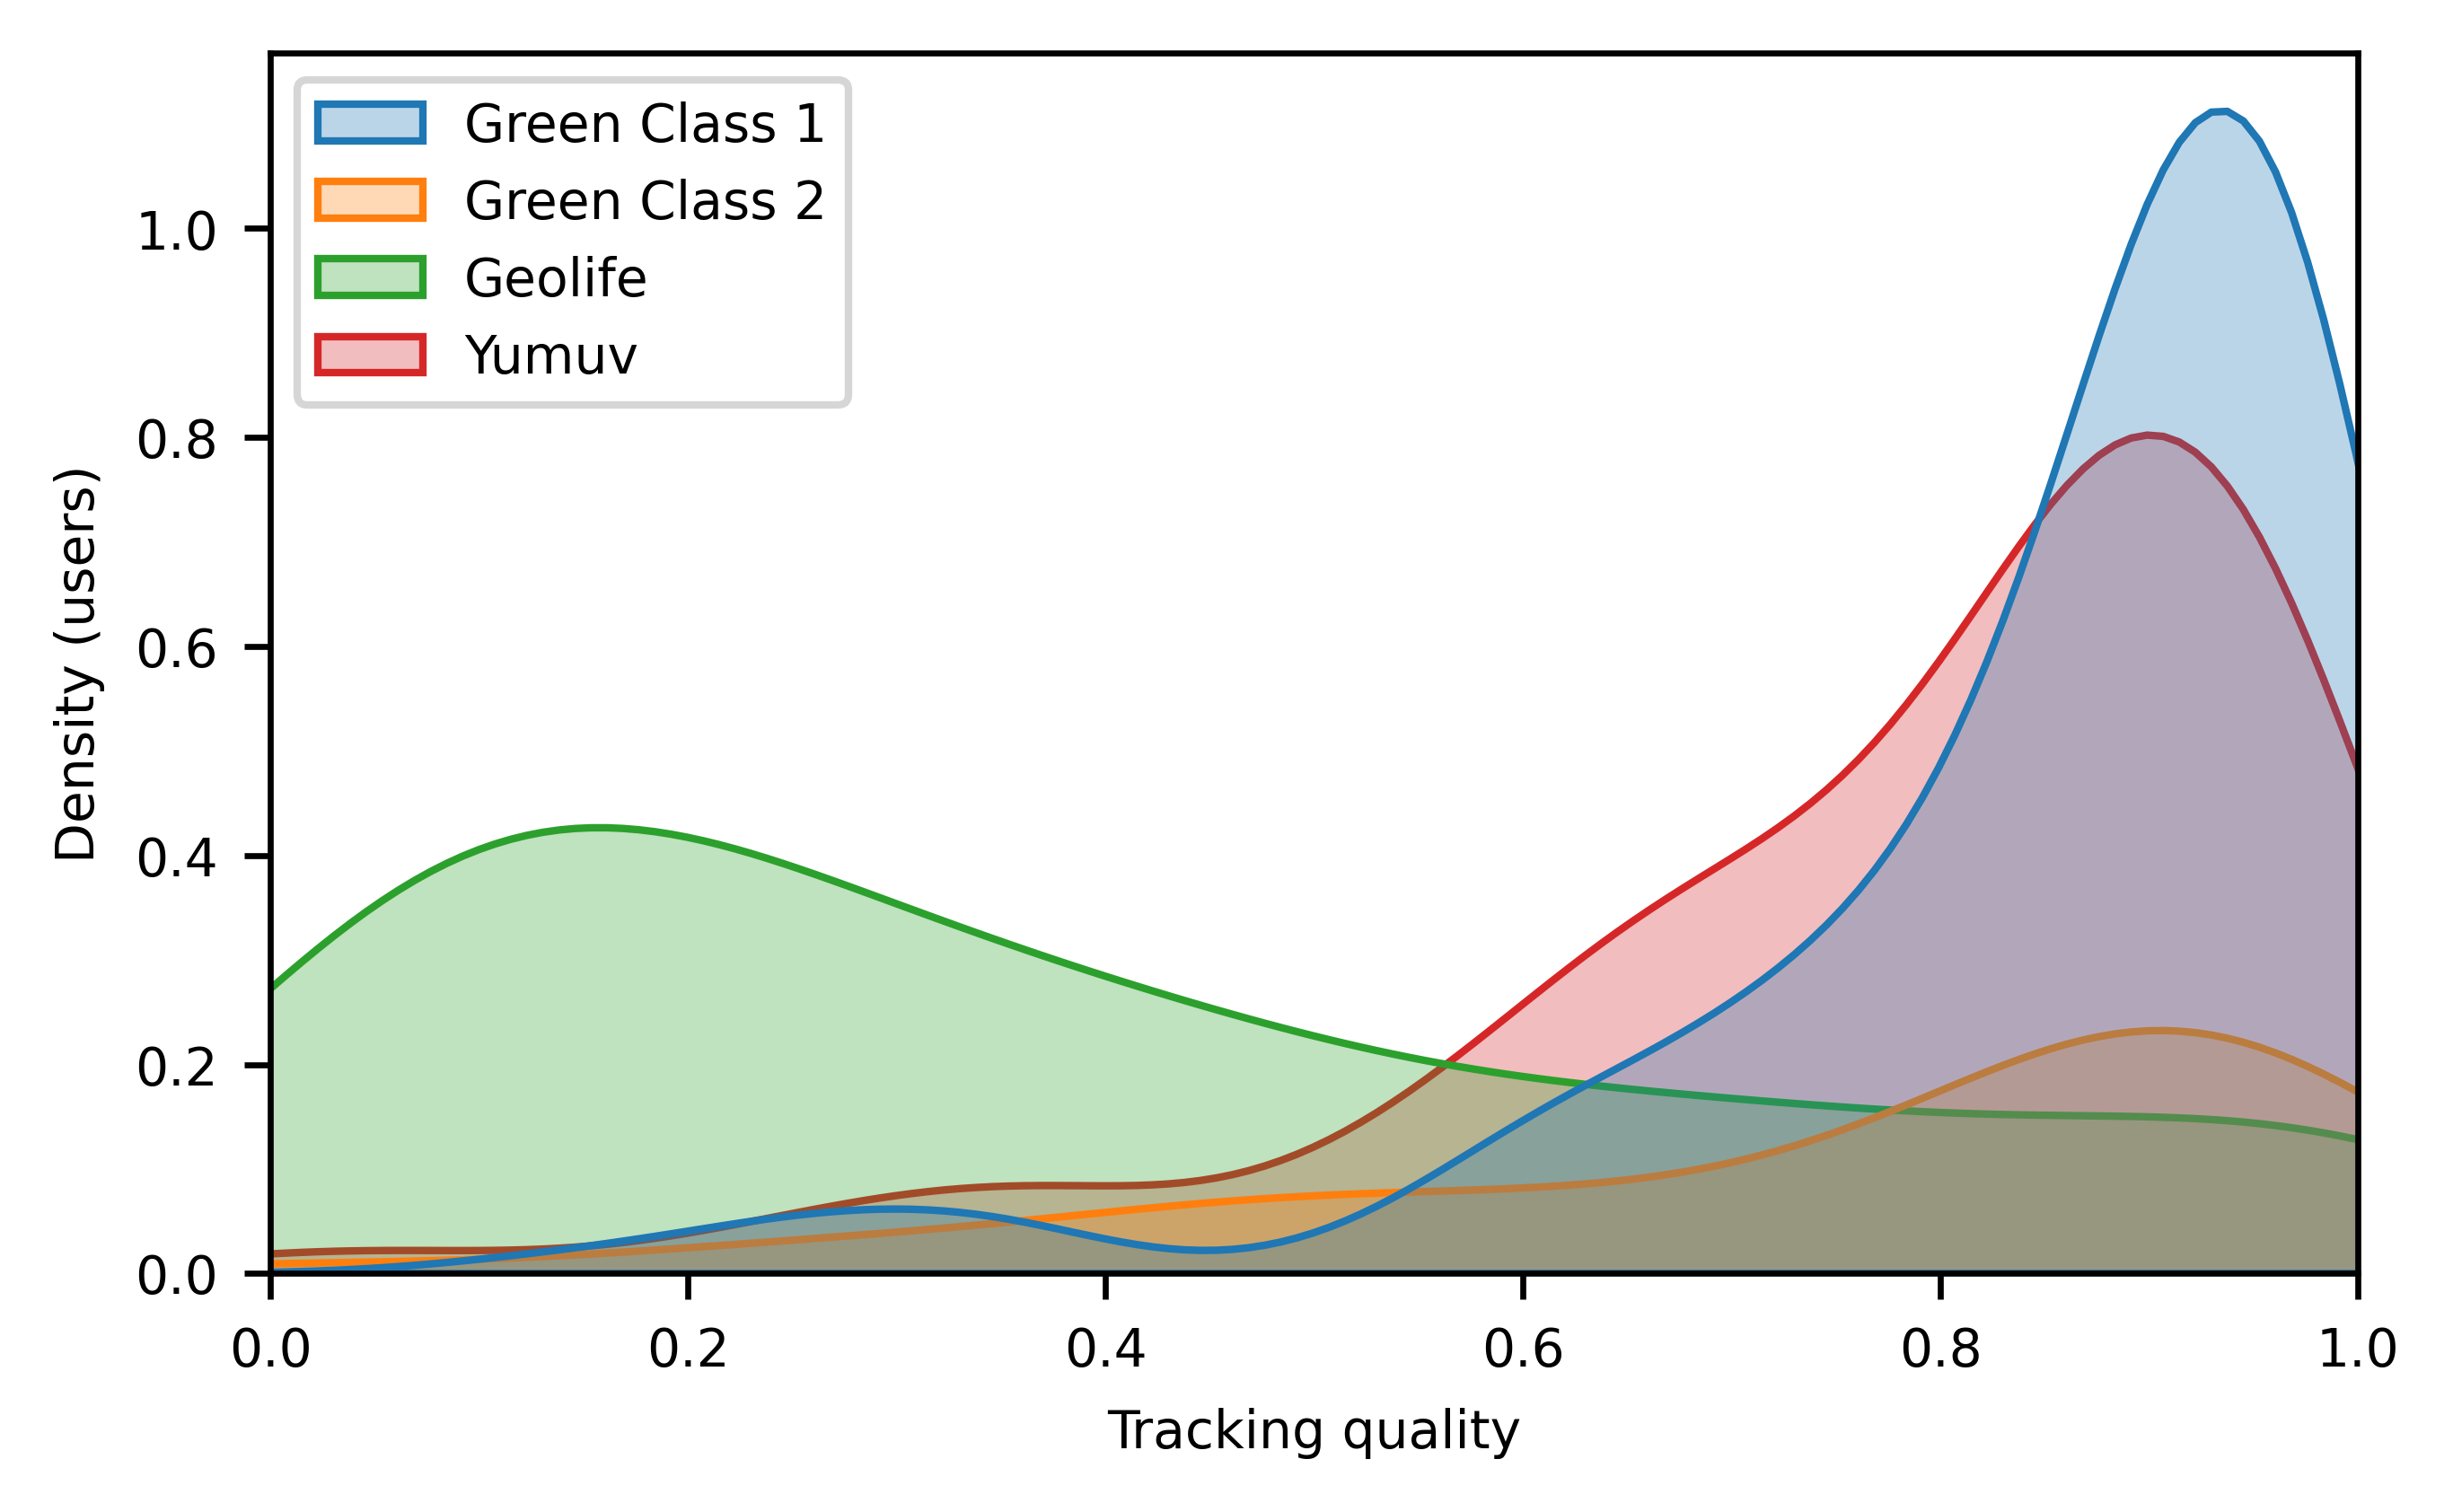

In [111]:
new_df = pd.DataFrame()

for key in ["gc1","gc2",  "geolife", "yumuv_graph_rep"]:
    study = study_mapping[key]
    new_df[study] = tracking_quality_dfs[key]["quality"]

plt.figure(figsize=(5,3))
plt.rcParams.update({"font.size": 15})
g = sns.kdeplot(data=new_df, fill=True, alpha=.3, legend=True, common_grid=True)
# sns.histplot(data=new_df, bins=100,common_norm=True, stat="density", kde=False)
plt.ylabel("Density (users)")
plt.xlabel("Tracking quality")
sns.move_legend(g, "upper left")
plt.xlim(0, 1)
plt.savefig(os.path.join(out_path, "tracking_quality_kde.png"))
plt.show()

## 6) Modal split dataset comparison

#### Main plotting function to compare the modal split of several studies

#### Apply Trackintel function to get the modes for Geolife

In [ ]:
sql = f"SELECT * FROM geolife.triplegs"
tpls_geolife = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col='geometry')
tpls_geolife = ti.analysis.labelling.predict_transport_mode(tpls_geolife)
# save intermediate results
# pd.DataFrame(tpls_geolife["mode"]).to_csv("1paper/data_properties/geolife_triplegs.csv")

### Get modal split for each study

In [ ]:
# get the modal split by count, by duration and by distance
modal_split_count = {}
modal_split_duration = {}
modal_split_distance = {}

# the modes have different column names dependent on the study
mode_cols = {"gc1": "mode_validated", "gc2": "mode_validated", 
             "geolife": "mode", "yumuv_graph_rep": "track_mode_corrected"}

for study in studies:
    # load triplegs
    if study=="geolife":
        tpls_loaded = tpls_geolife.copy()
    else:
        geom_col = "geometry" if study=="yumuv_graph_rep" else "geom"
        sql = f"SELECT * FROM {study}.triplegs"
        tpls_loaded = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col=geom_col)
        tpls_loaded["mode"] = tpls_loaded[mode_cols[study]]
    
    # count
    modal_split = ti.analysis.modal_split.calculate_modal_split(tpls_loaded, freq=None, metric='count', per_user=False, norm=True)
    modal_split_count[study] = modal_split.copy()
    # duration
    modal_split = ti.analysis.modal_split.calculate_modal_split(tpls_loaded, freq=None, metric='duration', per_user=False, norm=True)
    modal_split_duration[study] = modal_split.copy()
    
    # distance
    tpls_loaded["distance"] = ti.geogr.distances.calculate_haversine_length(tpls_loaded)
    modal_split = ti.analysis.modal_split.calculate_modal_split(tpls_loaded, freq=None, metric='distance', per_user=False, norm=True)
    modal_split_distance[study] = modal_split.copy()

### Plotting

In [ ]:
# we need to map the mode labels from GC1 / GC2 / Yumuv to the ones from geolife
mode_to_category = { 
    "fast_mobility": "fast",
    "motorized_mobility": "motorized",
    "slow_mobility": "slow",
    "airplane": "fast", 
    "bicycle": "slow",
    "boat": "slow",
    "bus": "motorized",
    "car": "motorized",
    "coach": "motorized",
    "ebicycle": "slow",
    "kick_scooter": "slow",
    "ecar": "motorized",
    "motorbike": "motorized",
    "ski": "slow",
    "train": "fast",
    "tram": "motorized",
    "walk": "slow"
}
# extent mode_to_category mapping with the upper case / colon versions
further_cols = list(modal_split_count["gc1"].columns)
for col in further_cols:
    mode_to_category[col] = mode_to_category[col.split("::")[1].lower()] 

In [ ]:
# Main plotting function
def plot_modal_split_comparison(name_df, modal_split_df):
    """
    name_df: str, just the name that it should be saved with
    modal_split_df: Dictionary of Dataframes, one Dataframe per study with the respective modal split
    """
    final_modal_split = defaultdict(dict)
    for study in studies:
        modal_split_dict = modal_split_df[study].to_dict()
        for key in modal_split_dict.keys():
            k_new = mode_to_category[key]
            if k_new in final_modal_split[study]:
                final_modal_split[study][k_new] += modal_split_dict[key][0]
            else:
                final_modal_split[study][k_new] = modal_split_dict[key][0]
    df_count = pd.DataFrame(final_modal_split).swapaxes(1,0)[["slow", "motorized", "fast"]]
    fields = df_count.columns
    df_count.rename(index={"gc1":"Green Class 1", "gc2": "Green Class 2", "yumuv_graph_rep": "Yumuv", "geolife":"Geolife"}, inplace=True)
    colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
    left = np.array(len(df_count) * [0])
    for idx, name in enumerate(fields):
        plt.bar(df_count.index,df_count[name].values, bottom=left, color=colors[idx], label=name)
        left = left + df_count[name].values
    fs = 10
    plt.legend(loc="upper right", framealpha=1, fontsize=fs)
    plt.xlabel("Dataset", fontsize=fs)
    plt.ylabel("Modal split", fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, f"modal_split_all_{name_df}.pdf"), bbox_inches='tight')
    plt.show()

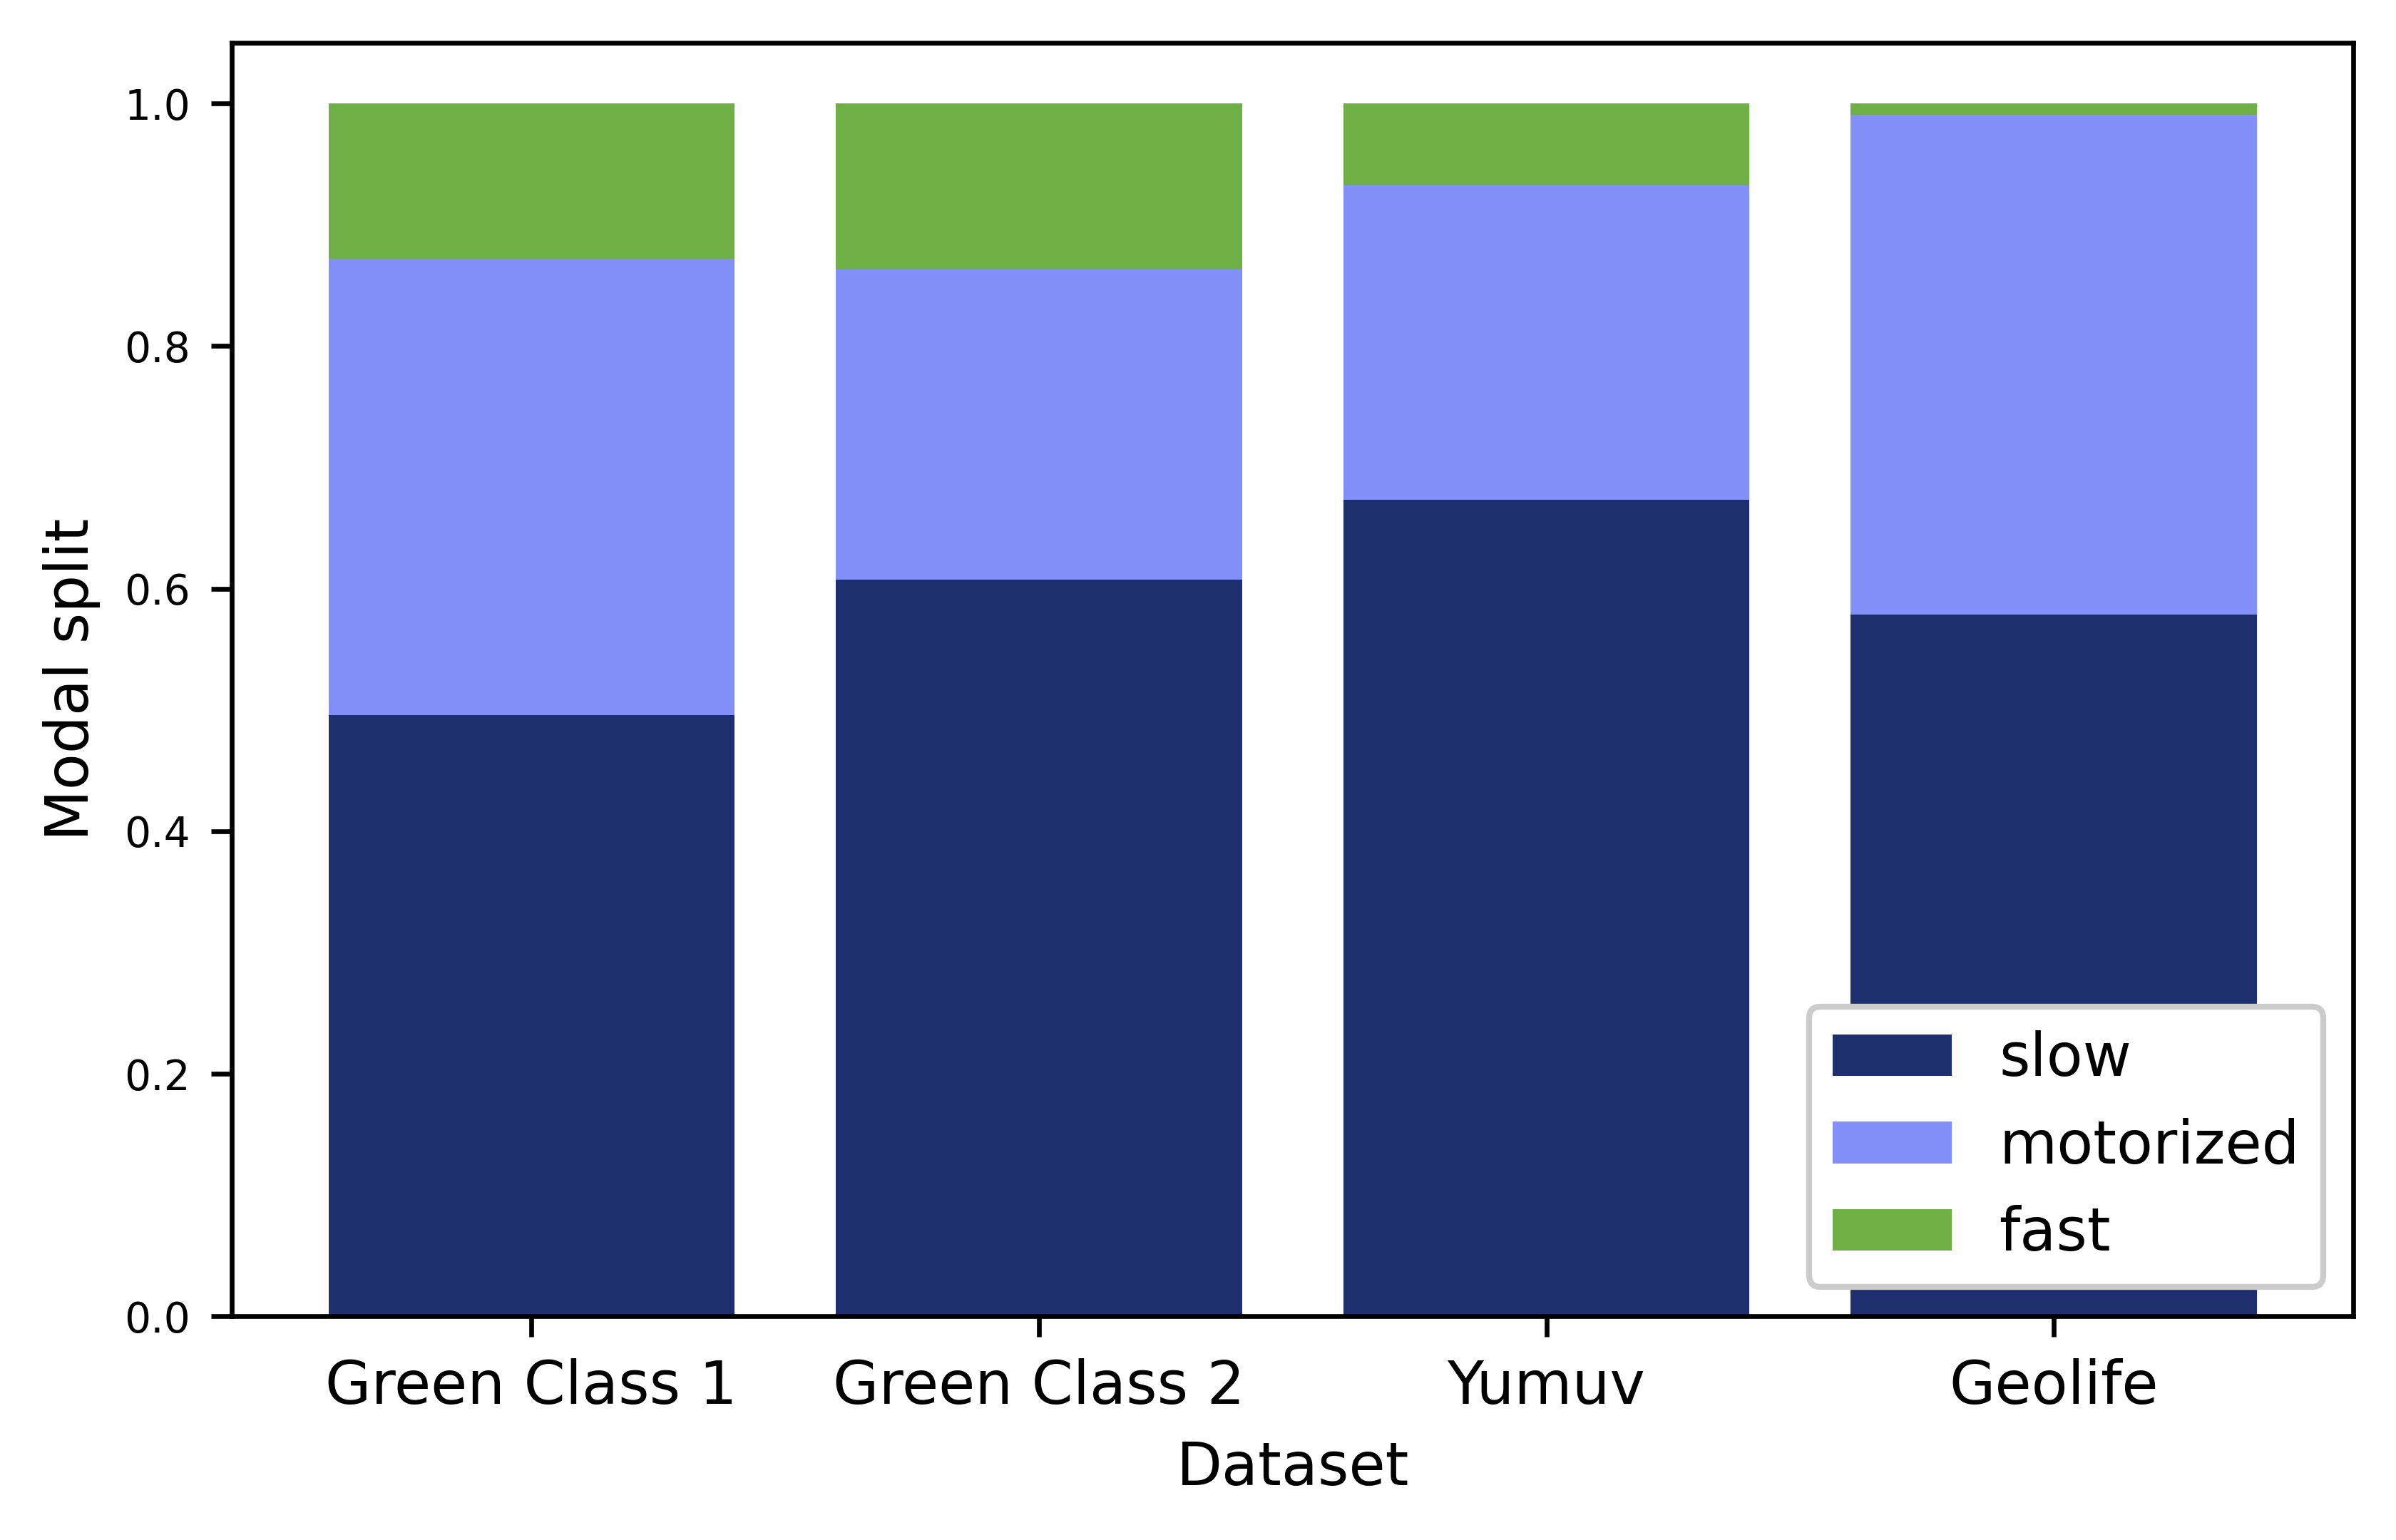

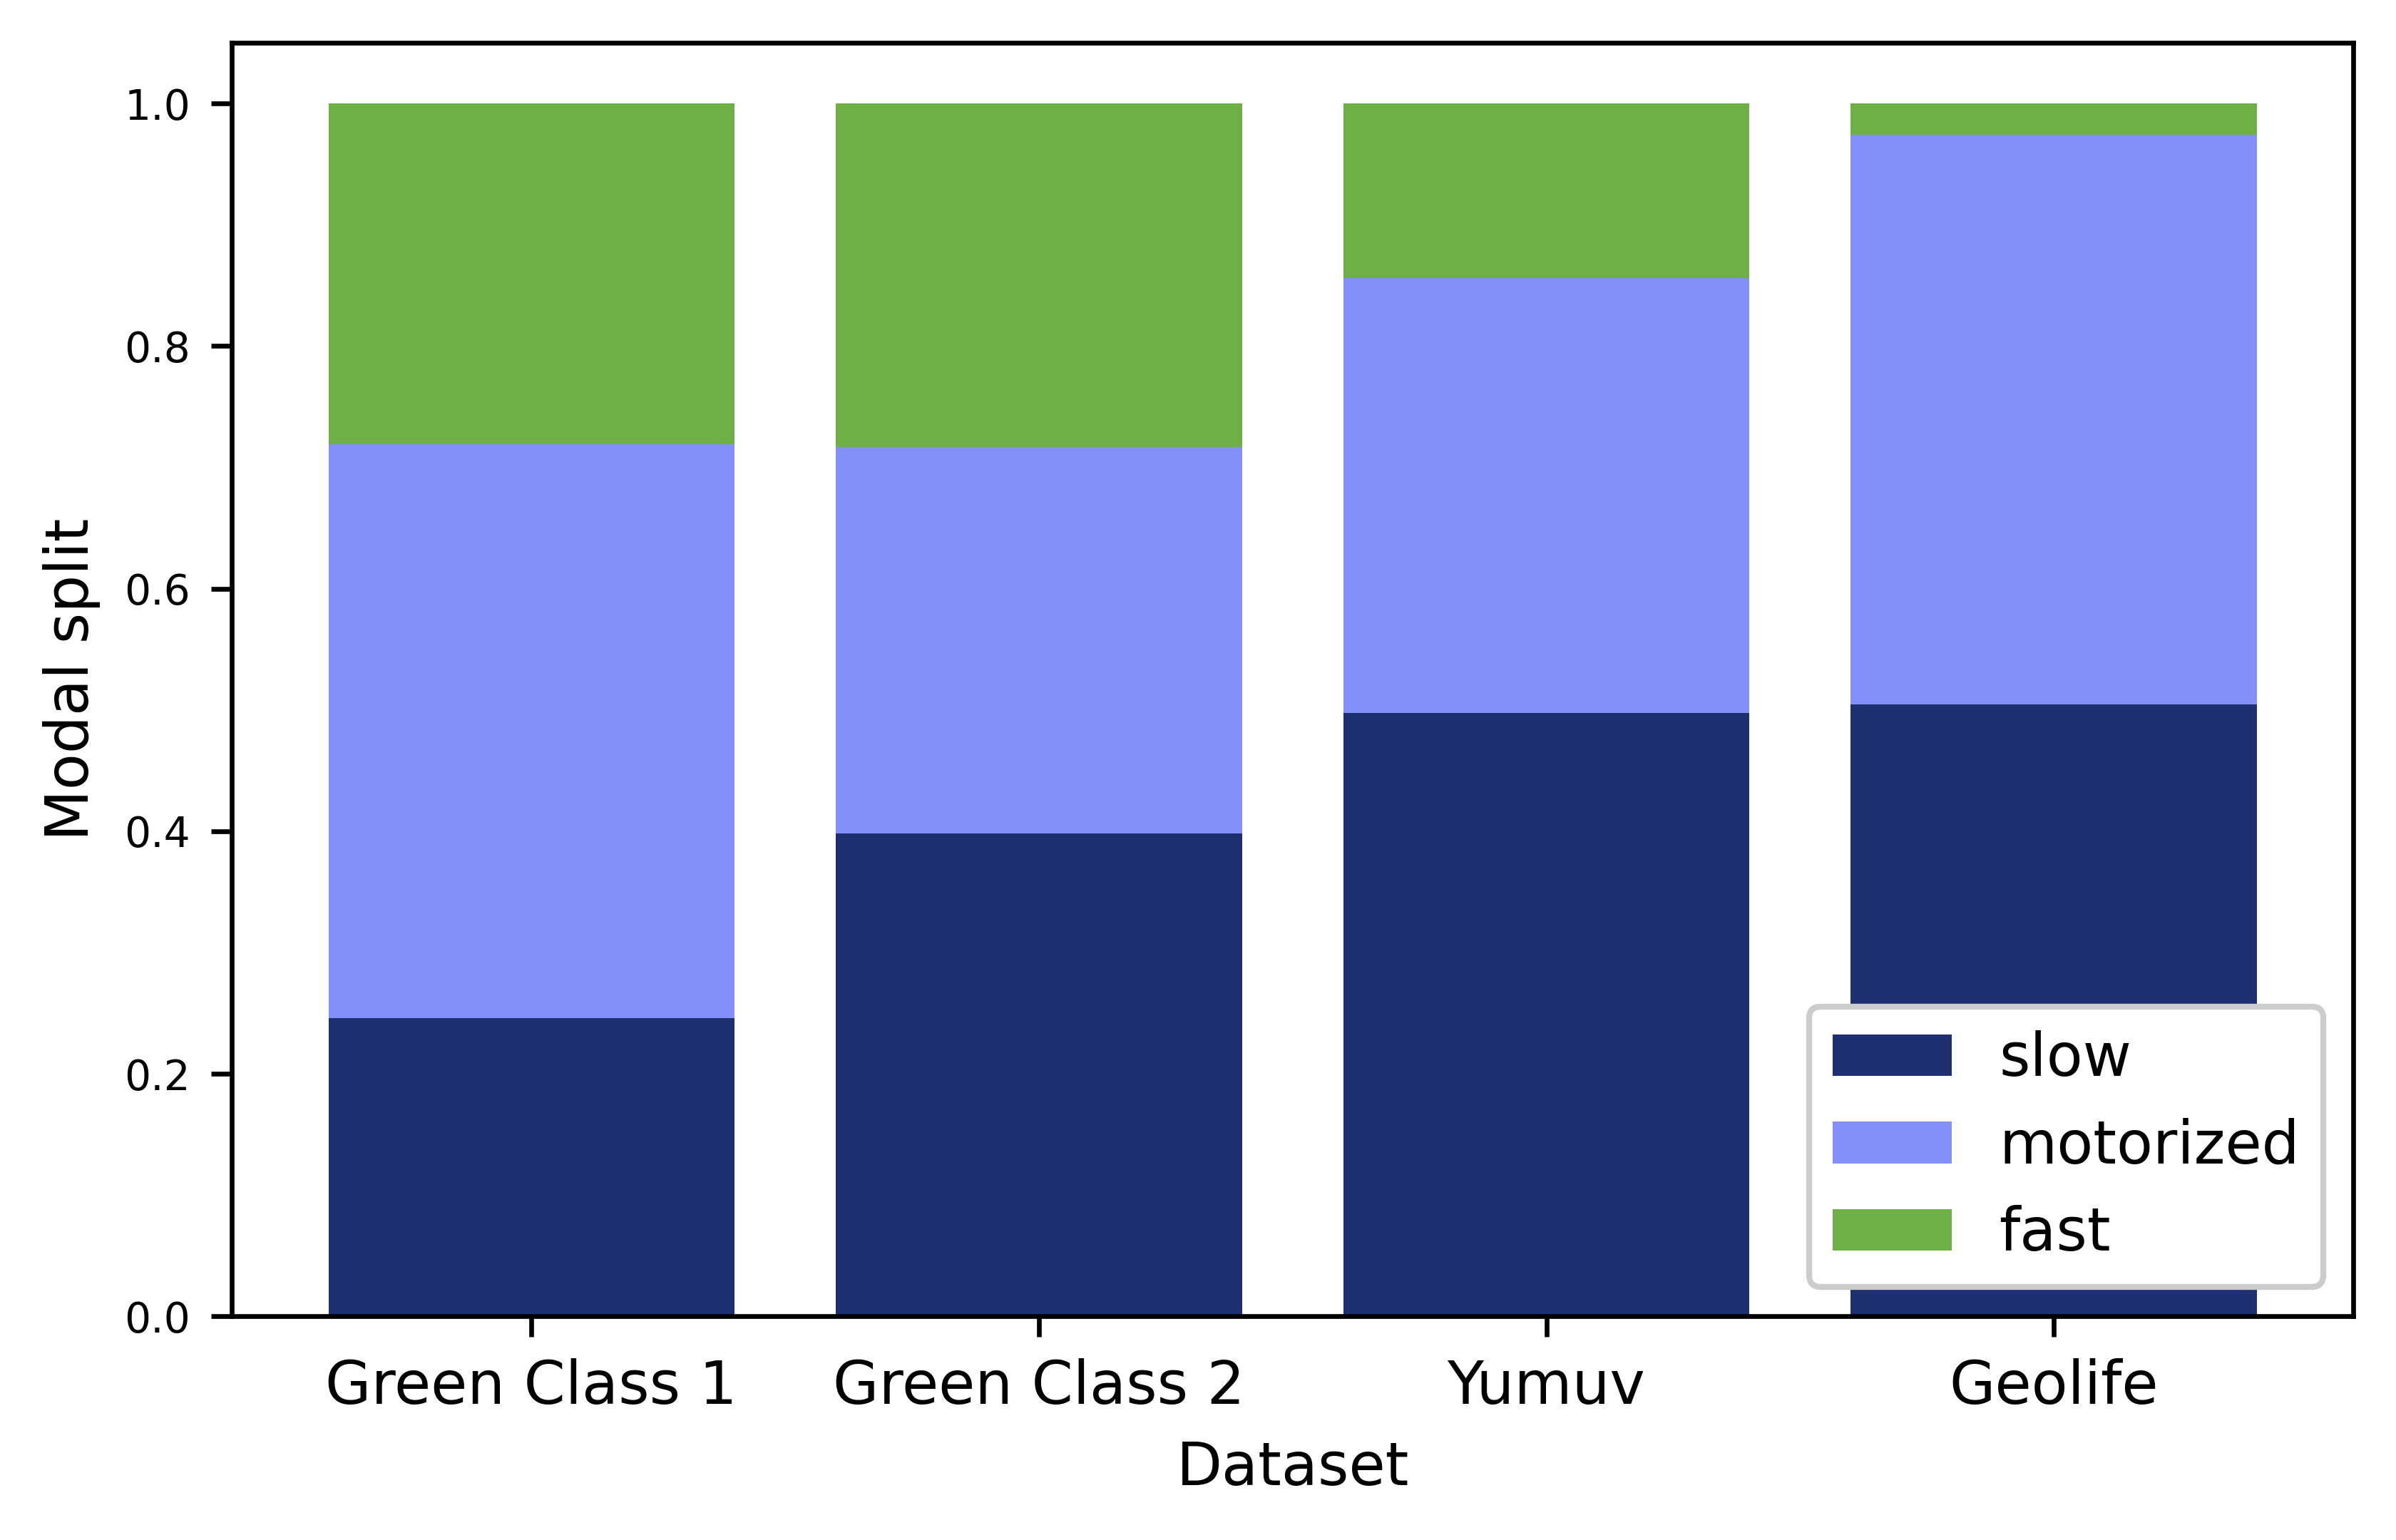

In [386]:
# plotting loop
for name_df, modal_split_df in zip(["count", "duration", "distance"],[modal_split_count, modal_split_duration, modal_split_distance]):
    plot_modal_split_comparison(name_df, modal_split_df)

## 7) Home / Work labeling

#### Collect work and home staypoints for GC1 and GC2

In [ ]:
sp_home = {}
sp_work = {}
for study in ["gc1", "gc2"]:
    sql = f"SELECT user_id, started_at, finished_at, purpose FROM {study}.staypoints WHERE purpose='[''home'']'"
    sp_home[study] = pd.read_sql(sql, con)
    sql = f"SELECT user_id, started_at, finished_at, purpose FROM {study}.staypoints WHERE purpose='[''work'']'"
    sp_work[study] = pd.read_sql(sql, con)

#### Compute staypoint purpose for Geolife and Yumuv

In [ ]:
for study in ["geolife", "yumuv_graph_rep"]:
    # load data - quicker when loading wihtout geometry and then make fake geometry
    sql = f"SELECT id, user_id, started_at, finished_at, location_id FROM {study}.staypoints"
    sp_loaded = pd.read_sql(sql, con)
    # fake geometry
    fake_geom = Point(1,2)
    sp_loaded["geom"] = fake_geom
    sp_loaded = gpd.GeoDataFrame(sp_loaded, geometry="geom")
    # convert times
    sp_loaded["started_at"] = pd.to_datetime(sp_loaded["started_at"], utc=True)
    sp_loaded["finished_at"] = pd.to_datetime(sp_loaded["finished_at"], utc=True)
    
    # add purpose with freq method
    sp_w_purpose = ti.analysis.location_identifier(sp_loaded, method="FREQ")
    
    # put in dict
    sp_home[study] = sp_w_purpose[sp_w_purpose["purpose"] == "home"][["user_id", "started_at", "finished_at", "purpose"]]
    sp_work[study] = sp_w_purpose[sp_w_purpose["purpose"] == "work"][["user_id", "started_at", "finished_at", "purpose"]]


In [ ]:
# save intermediate results
with open(os.path.join(out_path, "staypoints_home.pkl"), "wb") as outfile:
    pickle.dump(sp_home, outfile)
with open(os.path.join(out_path, "staypoints_work.pkl"), "wb") as outfile:
    pickle.dump(sp_work, outfile)

In [18]:
# load intermediate results
with open(os.path.join(out_path, "staypoints_work.pkl"), "rb") as outfile:
    sp_work = pickle.load(outfile)
with open(os.path.join(out_path, "staypoints_home.pkl"), "rb") as outfile:
    sp_home = pickle.load(outfile)

#### Plotting

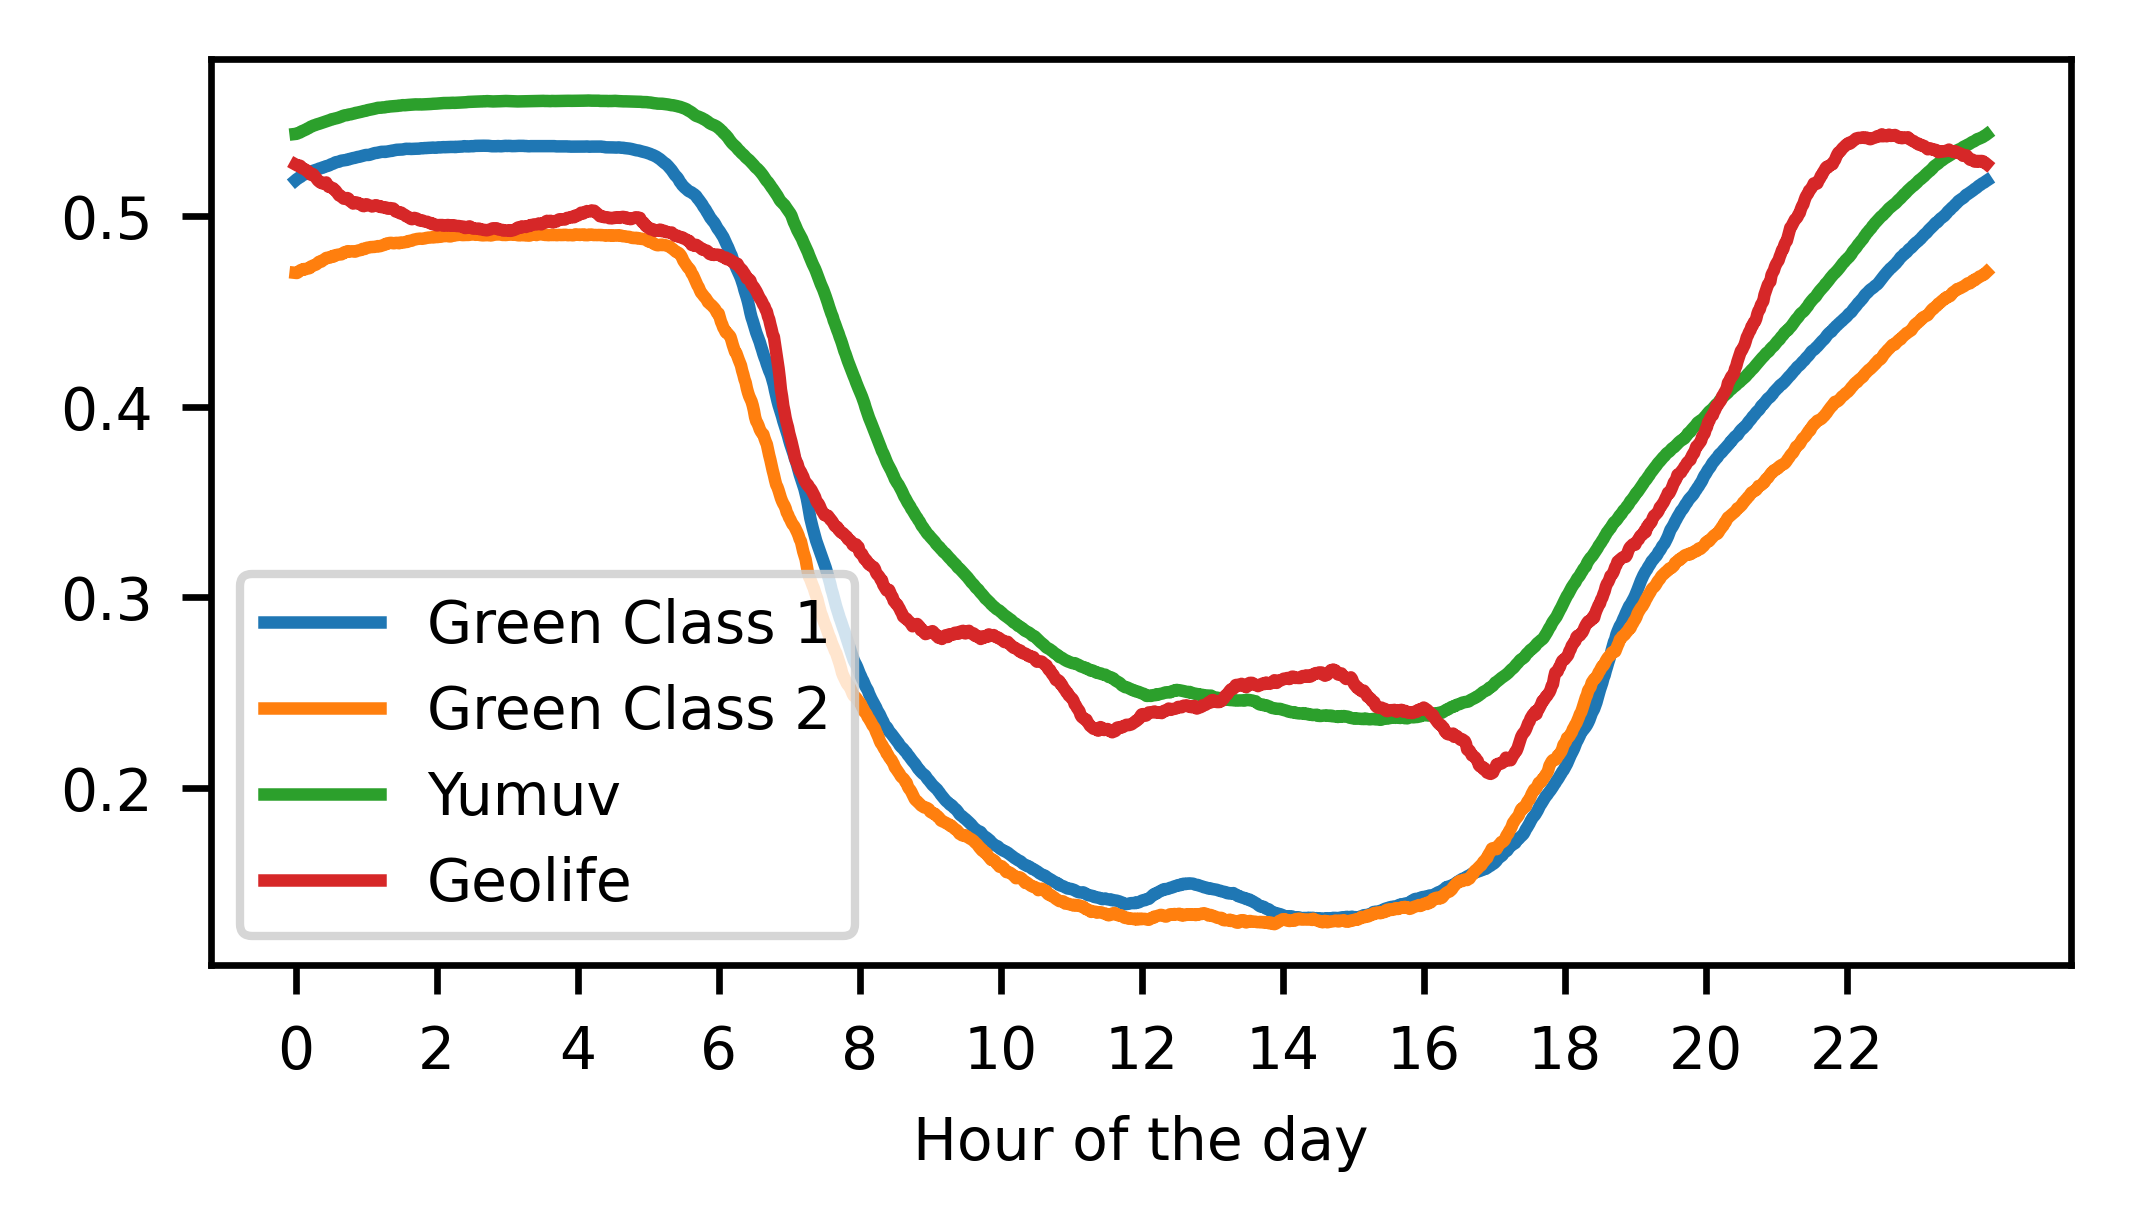

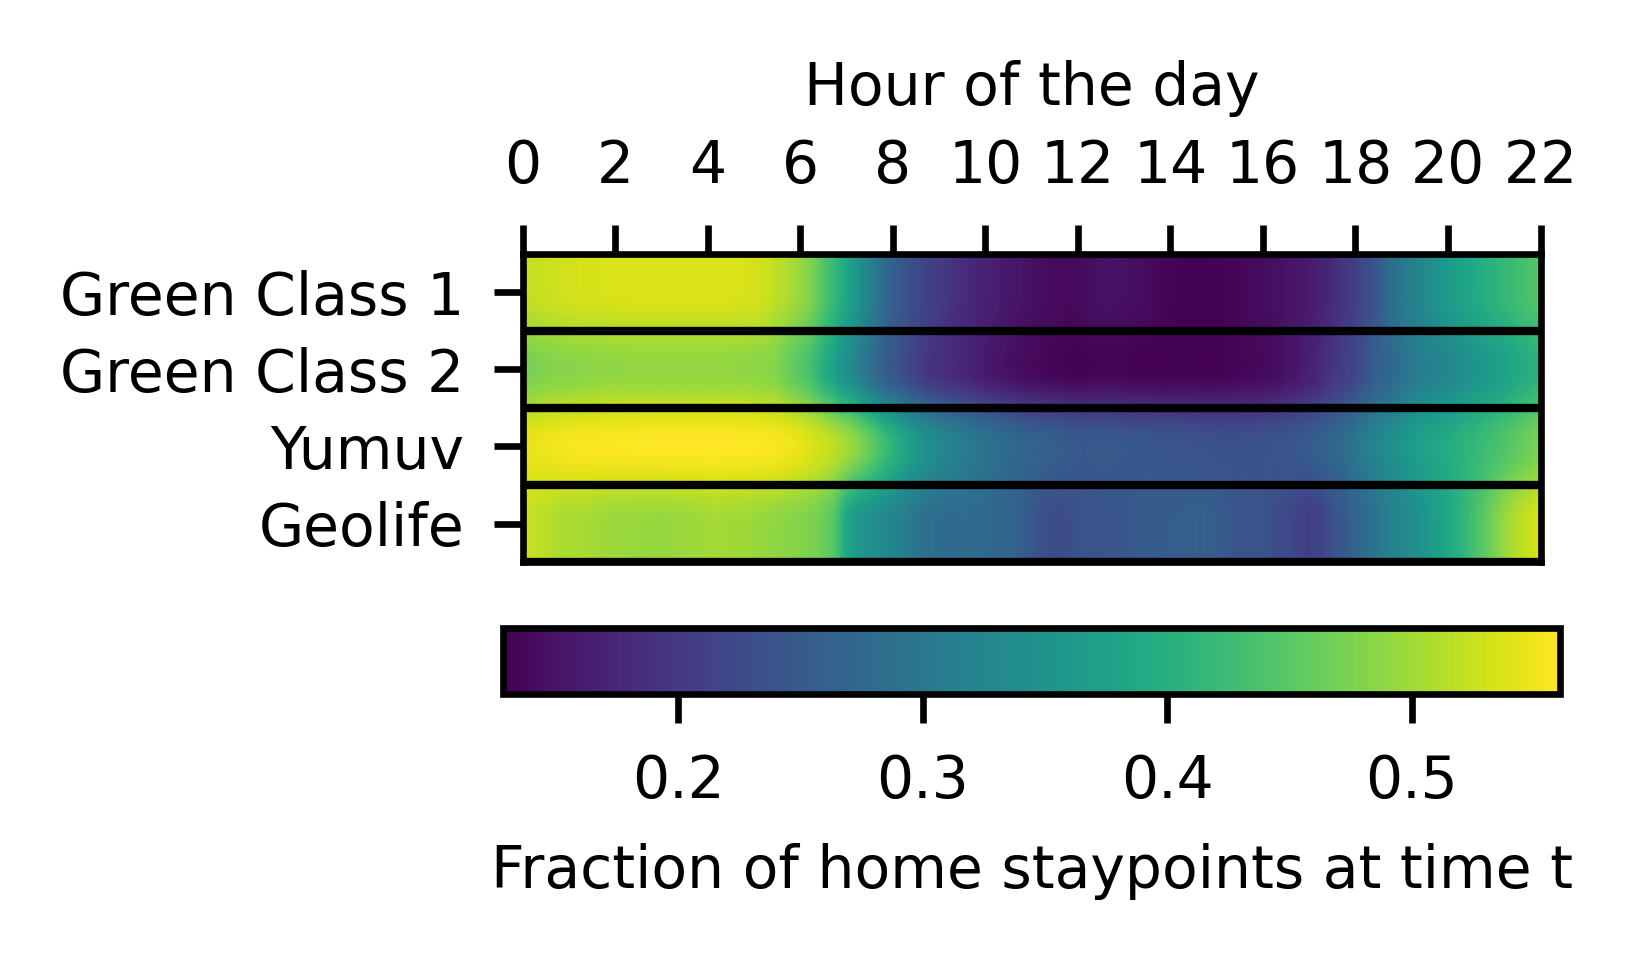

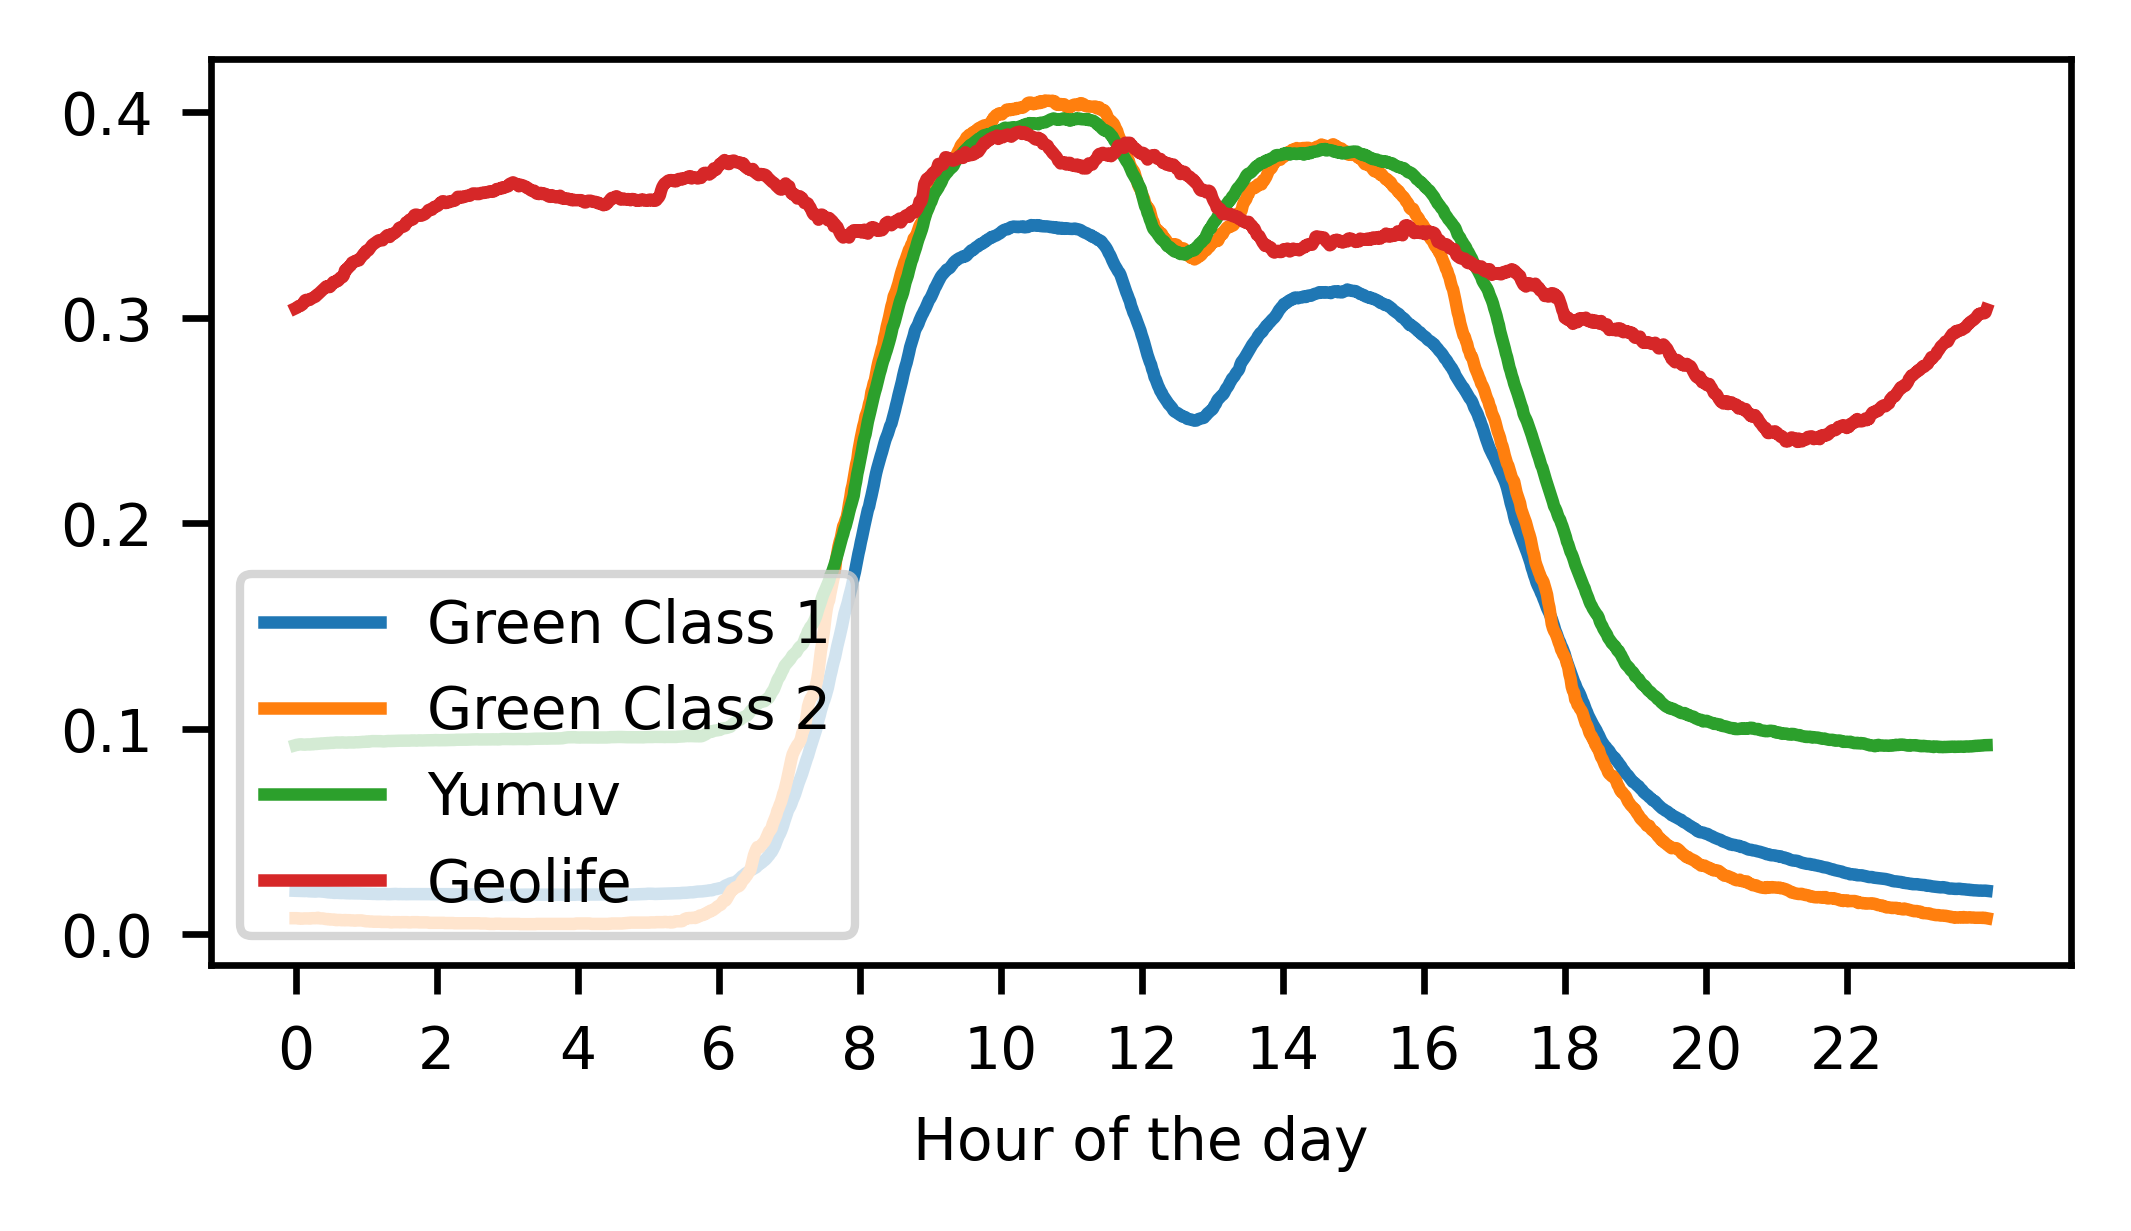

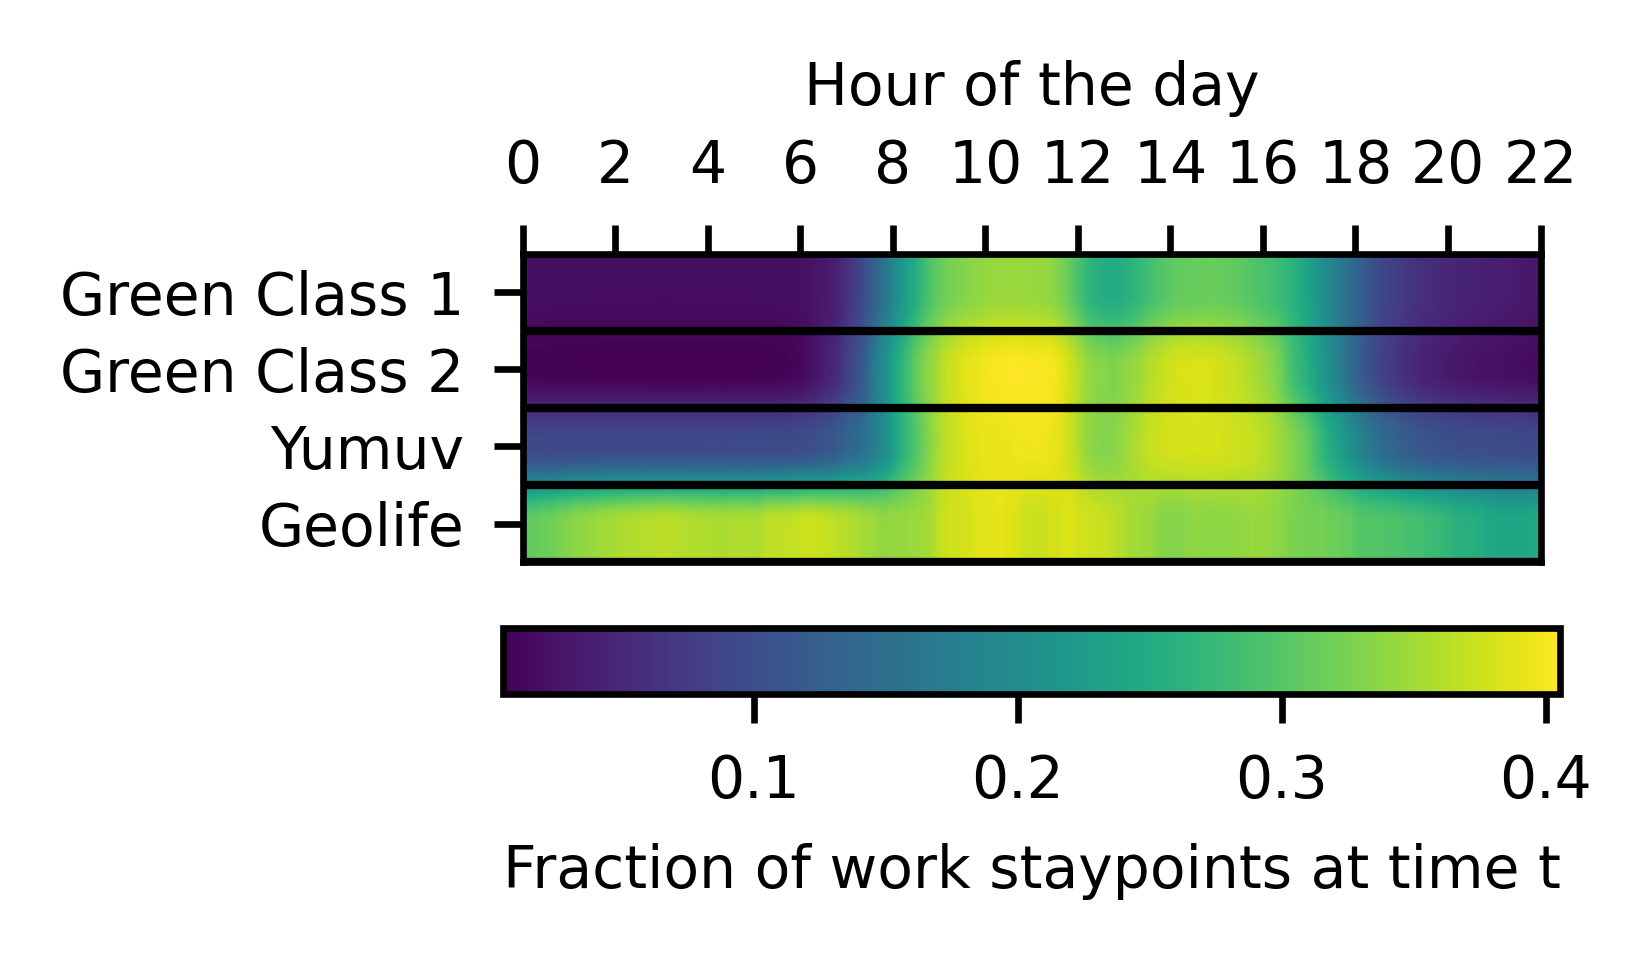

In [23]:
for sp_purpose, name in zip([sp_home, sp_work], ["home", "work"]):
    
    home_slots = []
    
    for study in studies:
        sp_study = sp_purpose[study]

        # init result array
        minute_slots = np.zeros(24 * 60)

        # convert timestamp columns
        sp_study_started = pd.to_datetime(sp_study["started_at"], utc=True)
        sp_study_finished = pd.to_datetime(sp_study["finished_at"], utc=True)
        if study != "geolife":
            sp_study["started_at"] = sp_study_started.dt.tz_convert("Europe/Paris")
            sp_study["finished_at"] = sp_study_finished.dt.tz_convert("Europe/Paris")
        else:
            sp_study["started_at"] = sp_study_started
            sp_study["finished_at"] = sp_study_finished

        # fill minute array
        for i in range(len(sp_study)):
            start = sp_study.iloc[i]["started_at"]
            end = sp_study.iloc[i]["finished_at"]
            if start.day != end.day:
                minute_slots[start.hour * 60 + start.minute : ] += 1
                minute_slots[: end.hour * 60 + end.minute] += 1
            else:
                minute_slots[start.hour * 60 + start.minute : end.hour * 60 + end.minute] += 1
        minute_slots = minute_slots / len(sp_study)

        if study == "geolife":
            # time shift
            minute_slots = np.roll(minute_slots, 7 * 60)
        
        home_slots.append(minute_slots)
    home_slots = np.array(home_slots)
    
    plt.figure(figsize=(4,2))
    for i in range(4):
        plt.plot(home_slots[i], label=study_mapping[studies[i]])
    plt.xticks(np.arange(0, len(minute_slots), 120), np.arange(0,24,2))
    plt.legend(loc="lower left")
    plt.ylabel=(f"Fraction of {name} staypoints covering time point")
    plt.xlabel("Hour of the day")
    # plt.savefig(os.path.join(out_path, f"plot_activity_distribution_{name}.pdf"))
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5,2))
    plt.imshow(home_slots, aspect=100)
    for i in range(4):
        plt.plot([0, home_slots.shape[1]], [i+.5, i+.5], c="black", lw=1)
    plt.xlim(0, 24)
    plt.yticks(np.arange(4), map(lambda x: study_mapping[x], studies))
    plt.xlabel("Hour of the day")
    ax.xaxis.tick_top()
    ax.xaxis.tickpad = -2
    ax.xaxis.set_label_position("top")
    plt.xticks(np.arange(0, len(minute_slots), 120), np.arange(0,24, 2))
    # ax.set_xticklabels(np.arange(0, len(minute_slots), 120), np.arange(0,24, 2))
    cbar = plt.colorbar(orientation="horizontal", ax=ax, aspect=16) #anchor=(-1, -1))
    cbar.set_label(f"Fraction of {name} staypoints at time t")
    plt.tight_layout()
    # plt.savefig(os.path.join(out_path, f"imshow_act_distribution_{name}.pdf"), bbox_inches='tight')
    plt.show()

## 8) Single user visualization

In [4]:
# function to limit the spatial extend of the shown region
def get_in_range(linestring):
    x, y = linestring.xy
    x = np.array(x)
    y = np.array(y)
    if all(y>39.8) and all(y< 41): # 9.8, 9.3, 4.6, # all(x < 9.8) and all(x>9.3)
        return True
    return False

In [5]:
# Load Geolife data of one user
sql = f"SELECT * FROM geolife.triplegs WHERE user_id=51"
tpls_vis = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col="geom")
tpls_vis["in_range"] = tpls_vis["geom"].apply(get_in_range)

In [6]:
# Get staypoints as well
sql = f"SELECT * FROM geolife.staypoints WHERE user_id=51"
sp_vis = ti.io.read_staypoints_postgis(sql, con, index_col="id", geom_col="geom")
sp_vis["in_range"] = sp_vis["geom"].apply(get_in_range)

In [7]:
# Load pfs
sql = f"SELECT * FROM geolife.positionfixes WHERE user_id=51"
pfs_vis = ti.io.read_positionfixes_postgis(sql, con, index_col="id")
pfs_vis["in_range"] = pfs_vis["geom"].apply(get_in_range)

In [ ]:
ti.visualization.plot_triplegs(tpls_vis[tpls_vis["in_range"]], 
                              staypoints = sp_vis[sp_vis["in_range"]],
                               plot_osm=True,
                                positionfixes=pfs_vis[pfs_vis["in_range"]],
                              staypoints_radius=150,
                              out_filename=os.path.join(out_path, "geolife_tpls_sp_pfs")
                              )

#### Plot only positionfixes

In [ ]:
ti.visualization.plot_positionfixes(pfs_vis[pfs_vis["in_range"]],
                                   plot_osm=True,
                                   out_filename=os.path.join(out_path, "geolife_pfs")
                                   )

#### Plot staypoints with positionfixes

In [ ]:
ti.visualization.plot_staypoints(sp_vis[sp_vis["in_range"]],
    positionfixes=pfs_vis[pfs_vis["in_range"]],
                                plot_osm=True,
                                 radius=150,
                                out_filename=os.path.join(out_path, "geolife_sp_pfs"
                                )

### 8.2) Modal split visualization

In [11]:
# Use GC2 user
sql = f"SELECT * FROM gc2.triplegs WHERE user_id='c9aa08e2-1a5d-4d41-ae62-6110a9072b23'"
tpls_vis = ti.io.read_triplegs_postgis(sql, con, index_col="id", geom_col="geom")

In [12]:
# rename to mode
tpls_vis["mode"] = tpls_vis["mode_detected"]

In [13]:
# compute modal split
modal_split = ti.analysis.modal_split.calculate_modal_split(tpls_vis, freq="M", metric='count', per_user=False, norm=True)

In [14]:
# order the transport modes for colour choices
column_order = ["Mode::Car", "Mode::Bicycle", "Mode::Walk", "Mode::Bus", "Mode::Train", "Mode::Ecar", "Mode::Ebicycle", "Mode::Airplane"]
modal_split = modal_split[column_order]

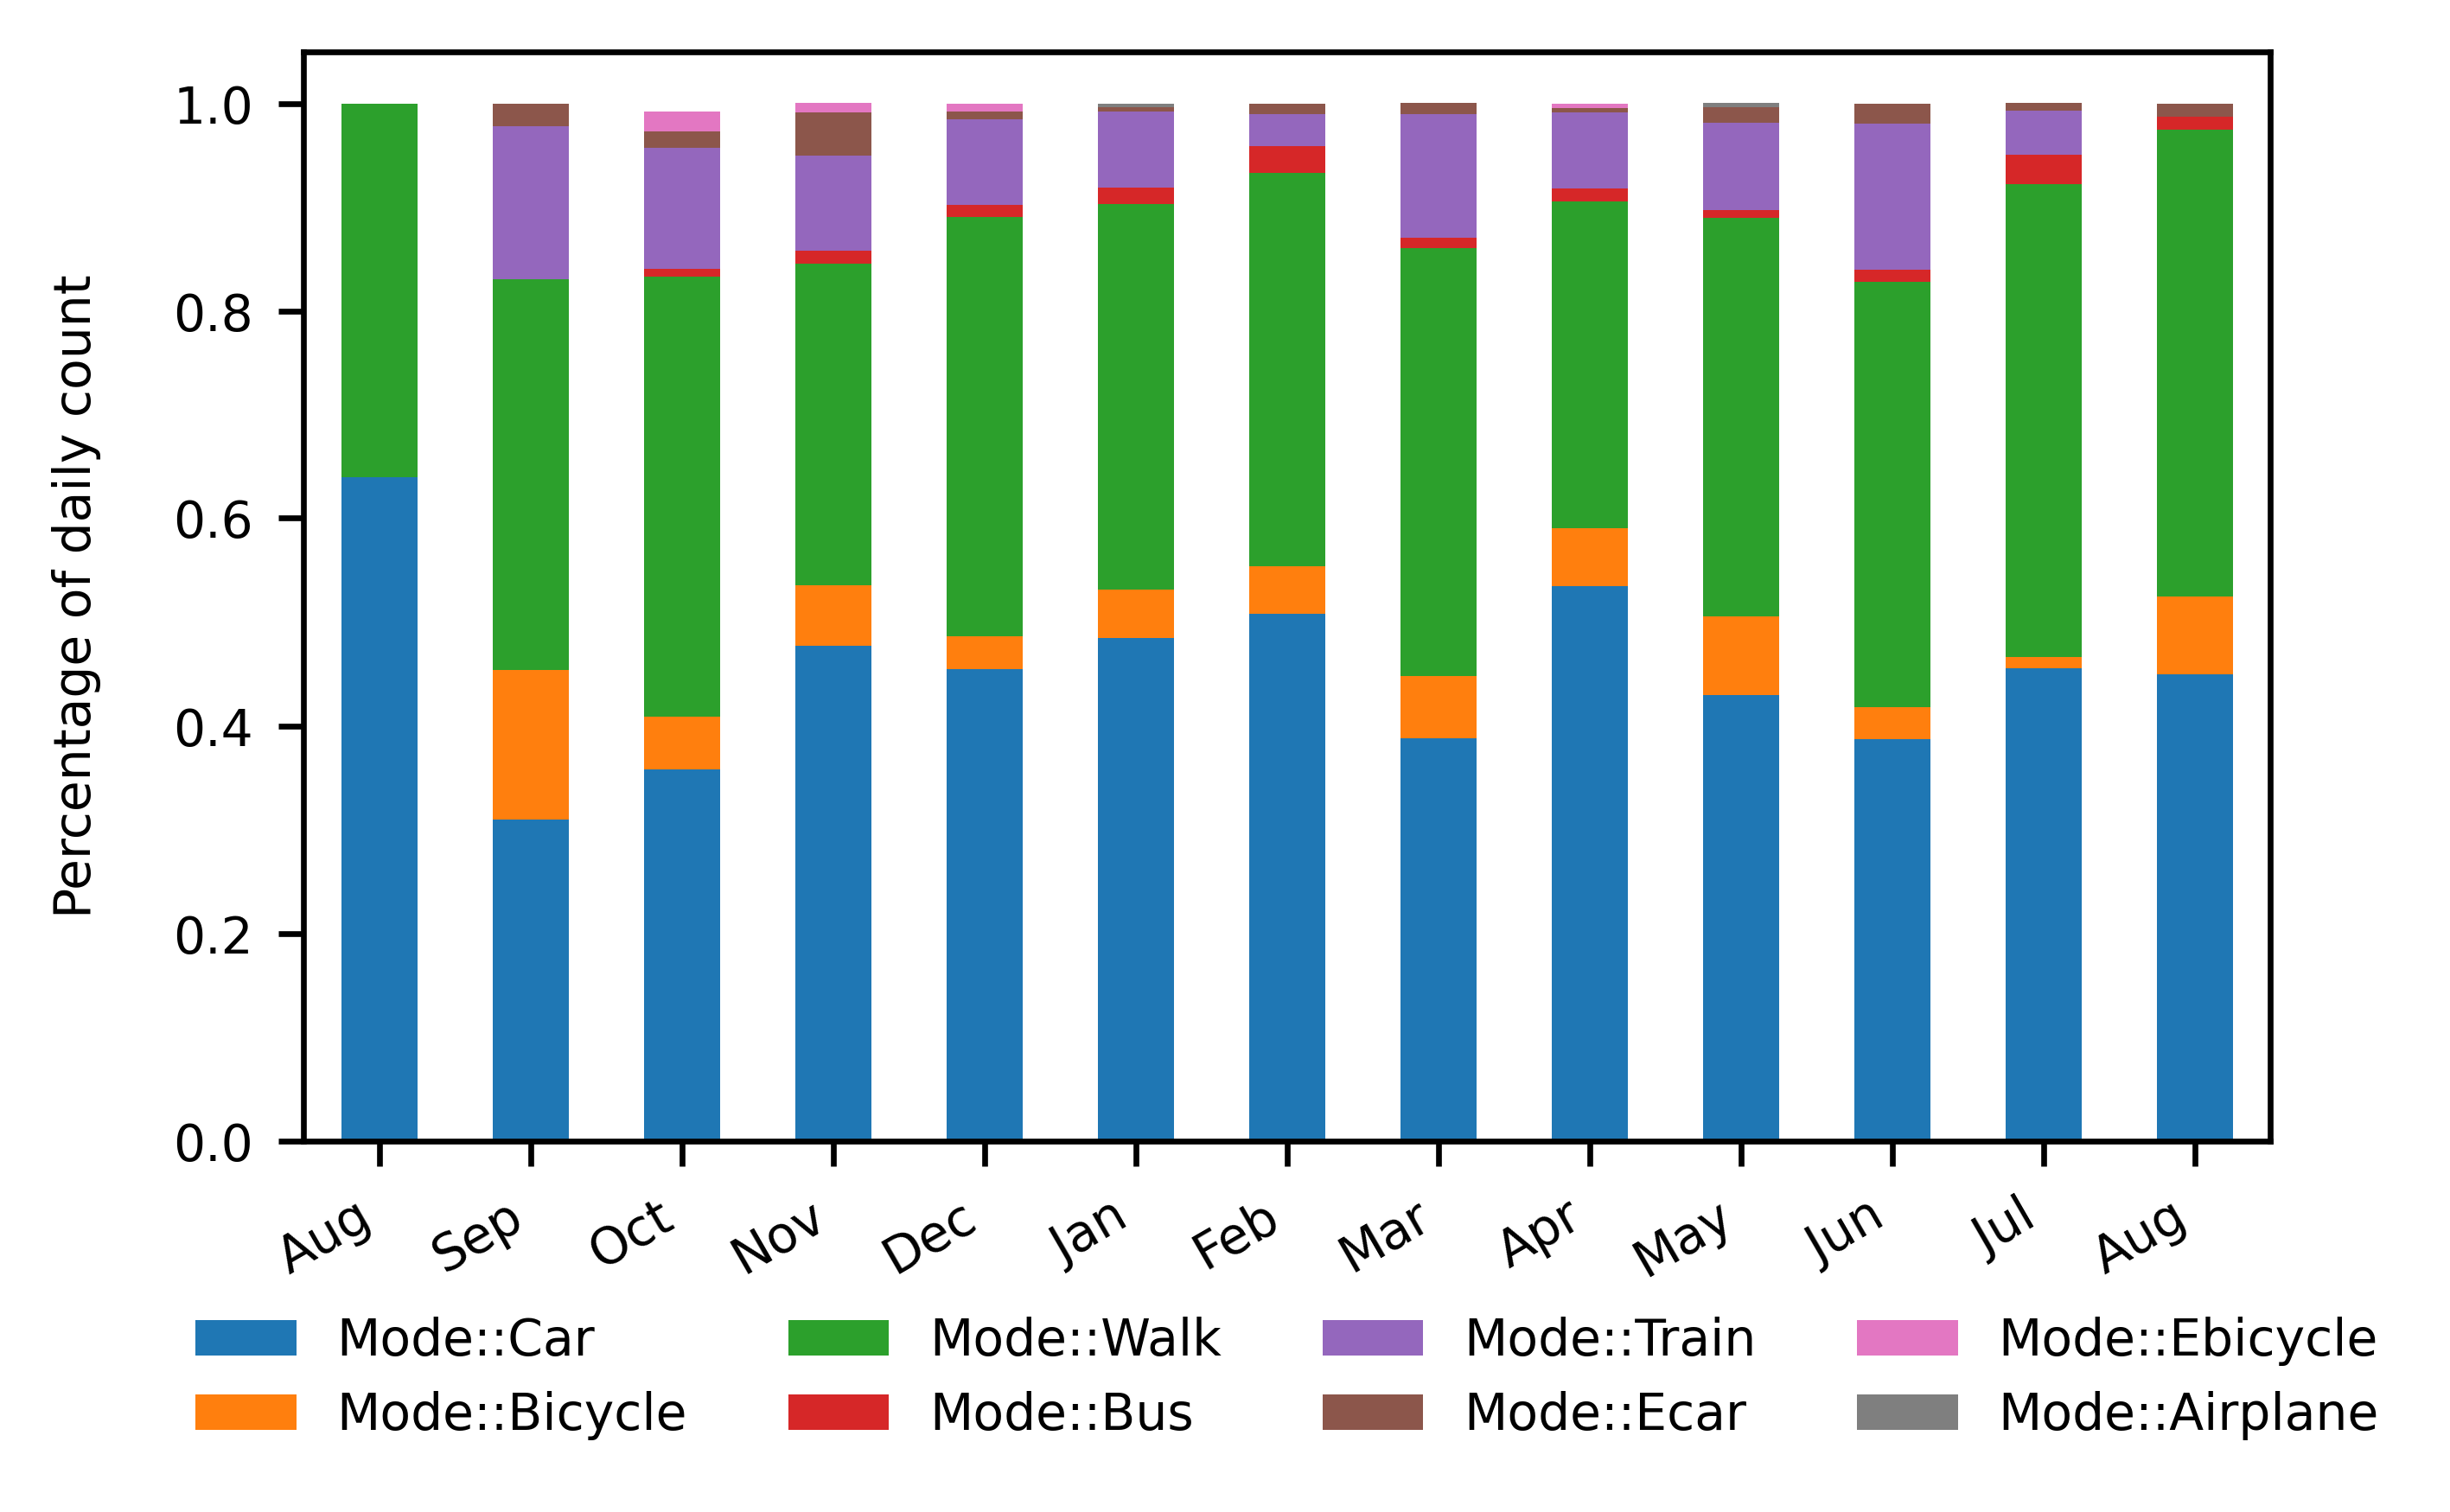

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
ax = ti.visualization.modal_split.plot_modal_split(modal_split, 
                                              date_fmt_x_axis='%b',
                                              y_label='Percentage of daily count',
                                              skip_xticks=0,
                                              n_col_legend=4,
                                              fs=20,
                                              axis=ax,
                                             borderaxespad=2
                                             )
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_count"))

#### Same for distance

In [16]:
modal_split = ti.analysis.modal_split.calculate_modal_split(tpls_vis, freq="M", metric='distance', per_user=False, norm=True)
modal_split = modal_split[column_order]

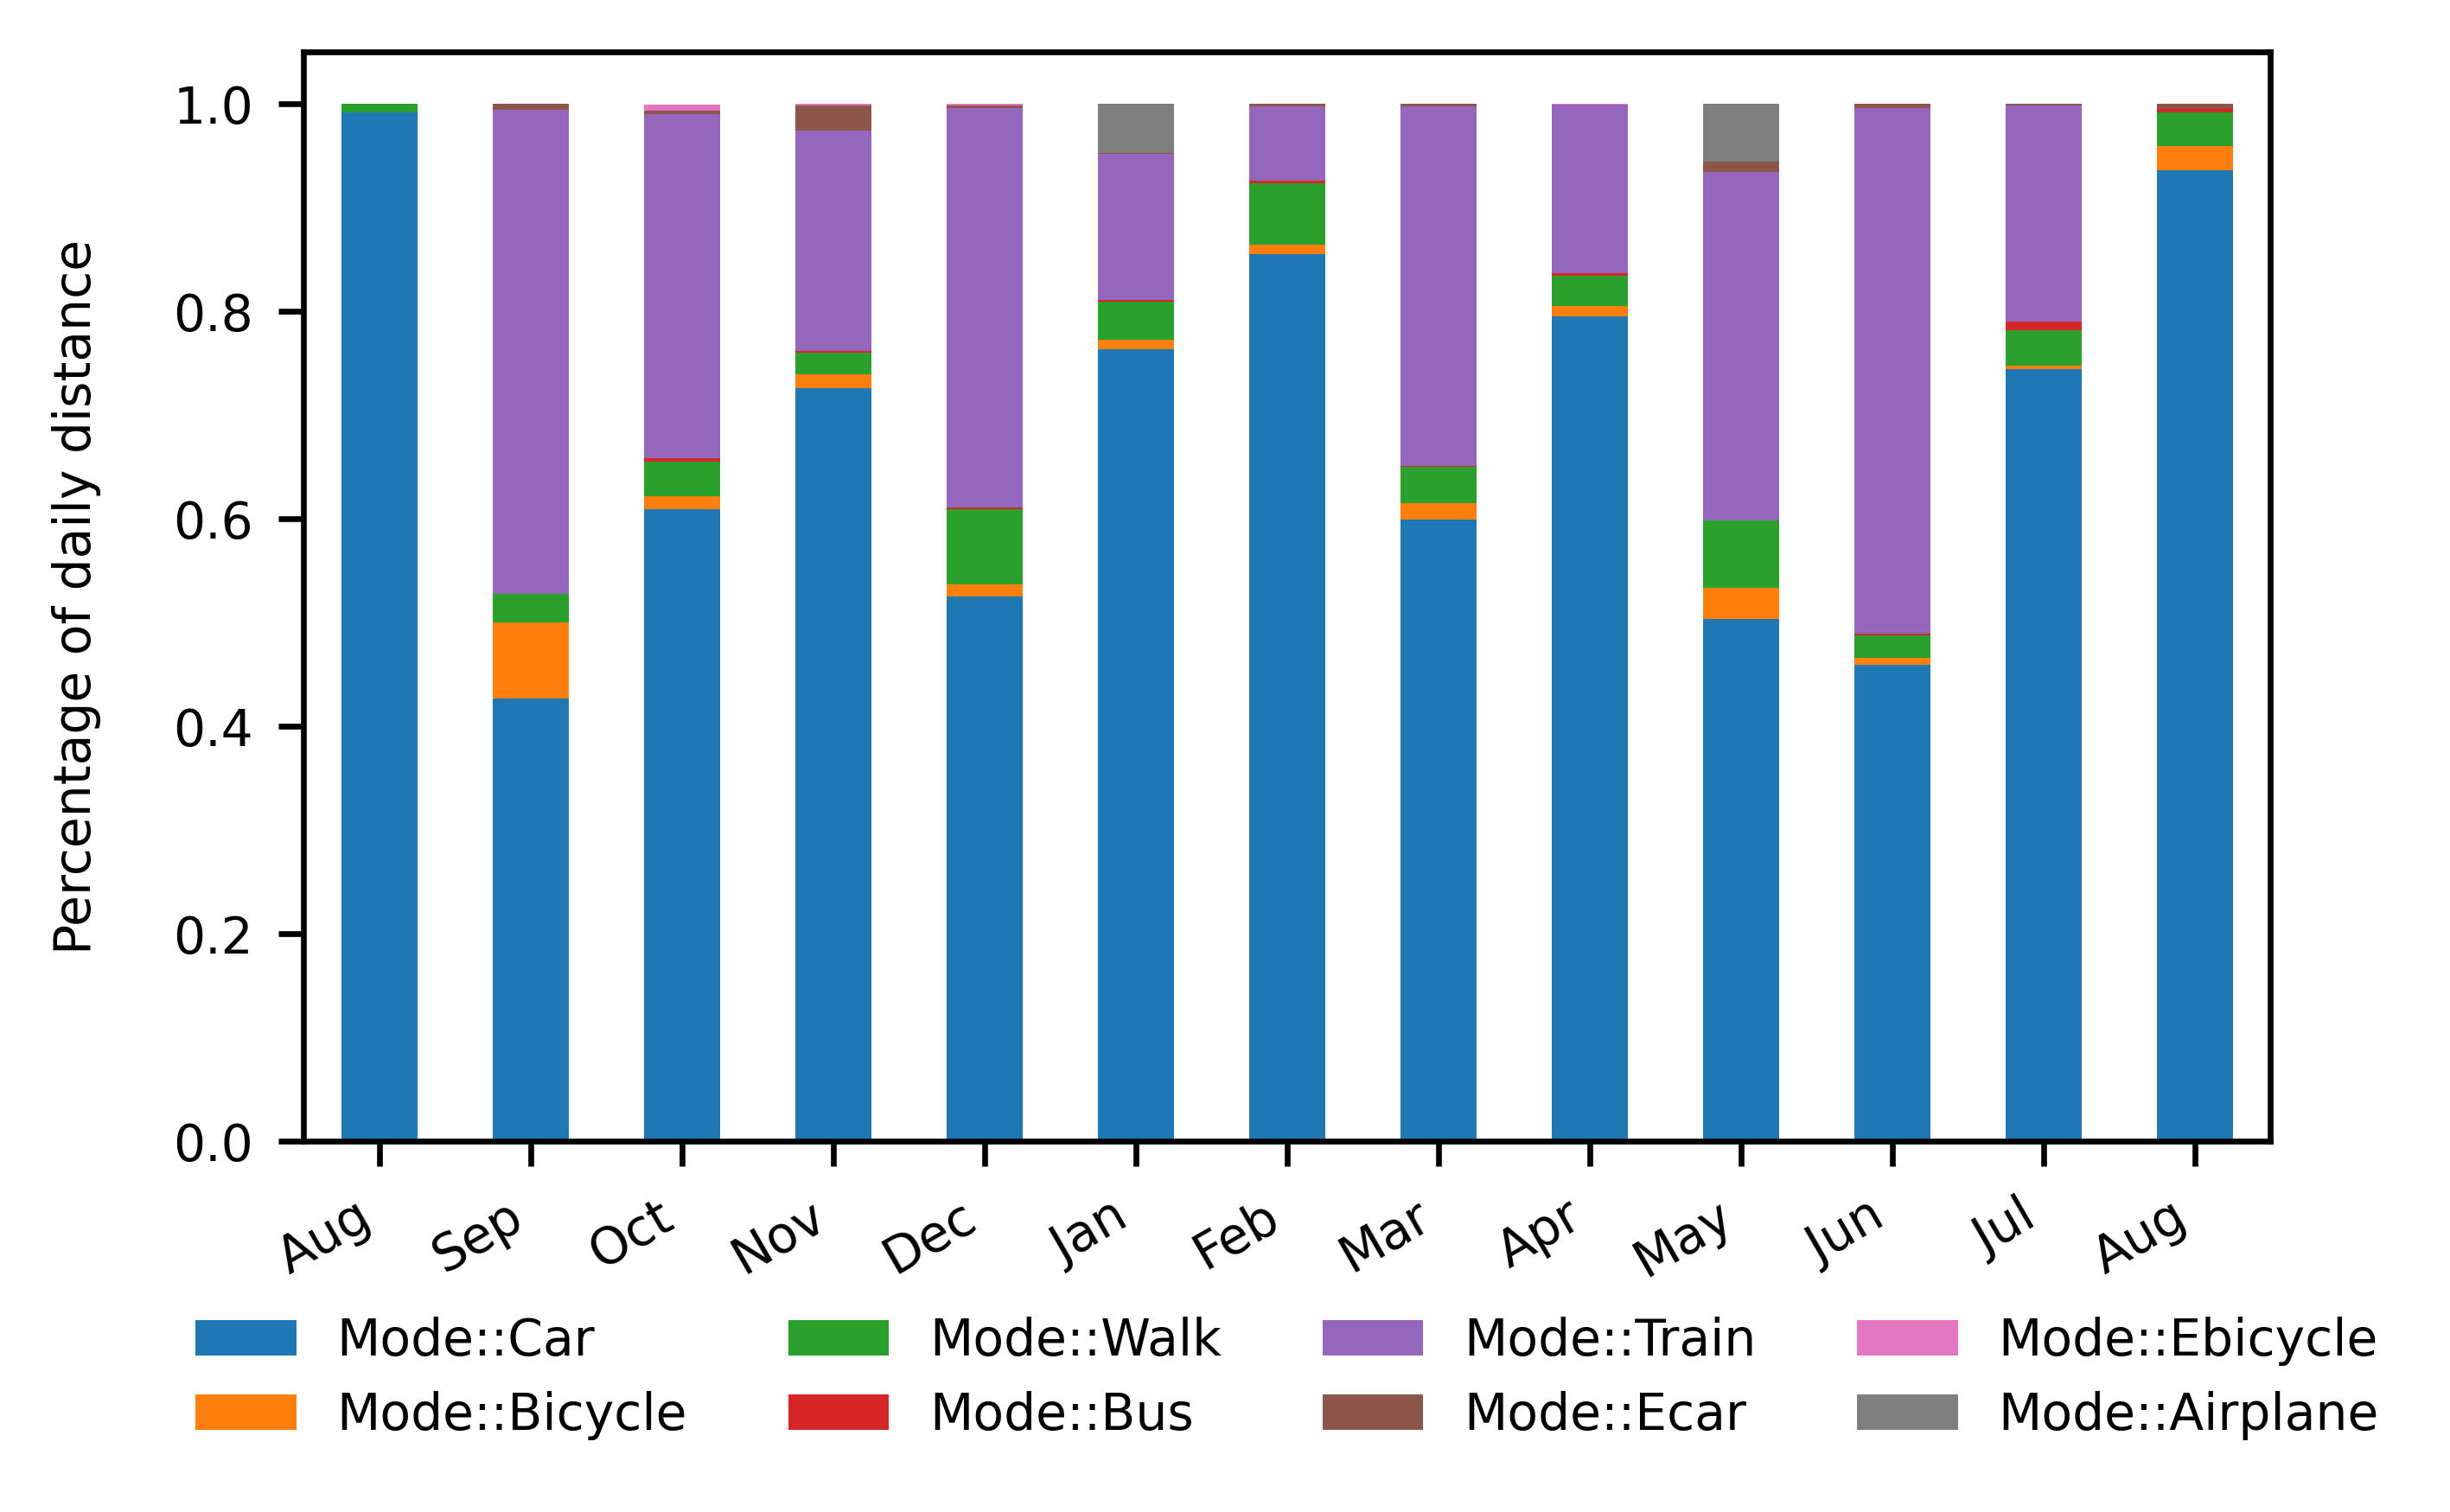

In [17]:
fig, ax = plt.subplots(figsize=(5,3))
ax = ti.visualization.modal_split.plot_modal_split(modal_split, 
                                              date_fmt_x_axis='%b',
                                              y_label='Percentage of daily distance',
                                              skip_xticks=0,
                                              n_col_legend=4,
                                              fs=20,
                                              axis=ax,
                                             borderaxespad=2
                                             )
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_distance"))